# Term Deposits Subscription Prediction
by Michele Casalgrandi

## Background
Care Bank is a bank planning to launch a new campaign to add term deposit subscriptions for its customer base.

A prior campaign had a conversion rate of more than 12%.

For the new campaign, Care Bank intend to use predictive models to increase success ratio and minimize the marketing budget.

## Objectives
* Identify customers that have a higher probability of subscribing to term deposit so they can be targeted in the new campaign

### Data Dictionary
Bank client data:
* age: Age of customer
* job: Type of job
* marital: Marital status of customer
* education: Eduction of customer
* default: has credit in default?
* housing: has housing loan?
* loan: has a personal loan?
* balance: balance in the account
* contact: contact communication type

Related to this campaign:
* month: last contact month of the year
* ~~day_of_week: last contact day of the week~~   
    day: day of the month of last contact (?)
* campaign: number of contacts performed during this campaign and for this client

Related to the previous campaign:
* pdays: number of days that passed by after the client was last contacted from a previous campaign
* previous: number of contacts performed before this campaign and for this client
* poutcome: outcome of the previous marketing campaign
* Output variable- Target: has the client subscribed to a term deposit? 

Customer interaction data:
* duration: last contact duration, in seconds 

##### Import libraries and load data

In [242]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()

import warnings

warnings.filterwarnings("ignore")

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# To build linear model for prediction
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier

from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV

# To check model performance
from sklearn import metrics

# set random seed for consistent results across runs
np.random.seed(1)

overall_start_time = time.time()

In [243]:
# Load data
df = pd.read_csv('bank-full.csv')

In [244]:
df.shape

(45211, 17)

The data set contains 45211 observations with 17 columns each.

In [245]:
# View first rows
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [246]:
# View last rows
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


There are no null values in the data set.

In [248]:
# check for duplicates
df.duplicated().sum()

0

There are no duplicates in the data set.

### EDA
#### Univariate analysis

In [249]:
# get statistics for the numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [250]:
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
def histogram_boxplot(feature, figsize=(15,15), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

### Numerical variables distributions

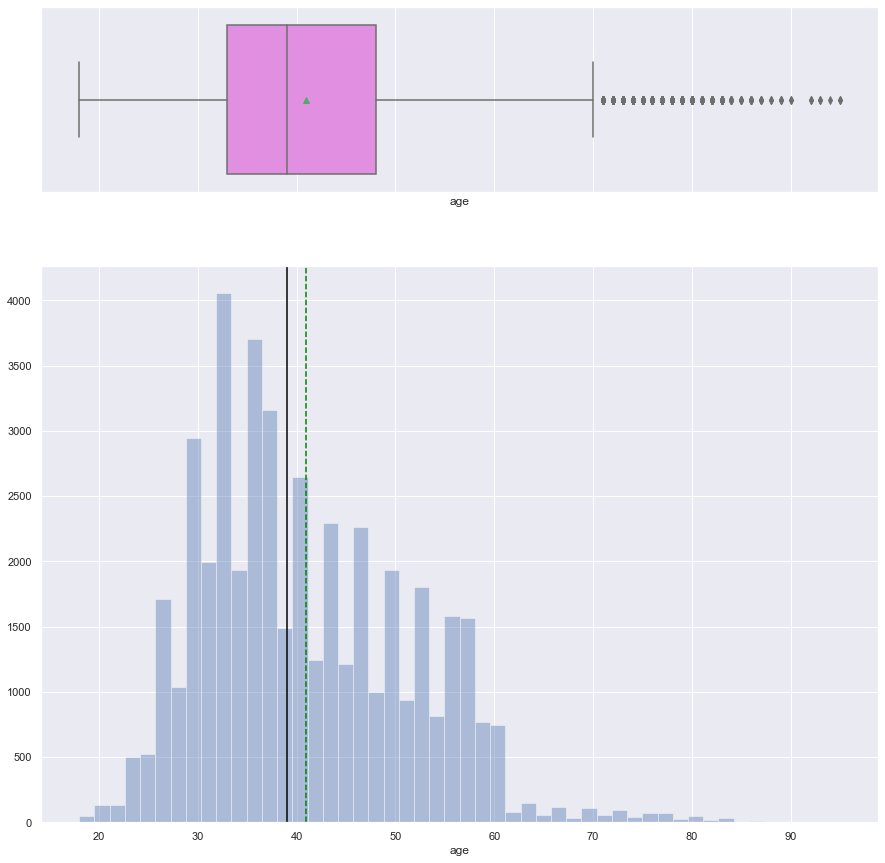

In [251]:
histogram_boxplot(df['age'])

'age' is skewed to the right with a number of outlier.  Outliers seem to be legitimate. 

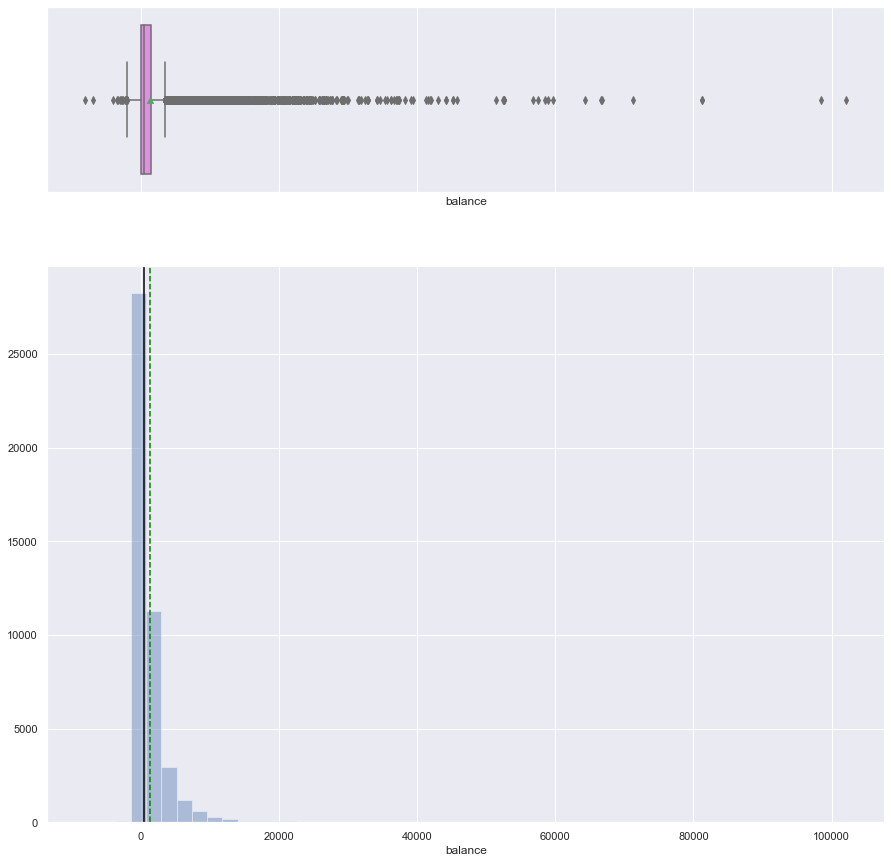

In [252]:
histogram_boxplot(df['balance'])

`balance` is highly skewed to the right with a large number of outlier.
3766 customers have negative balance.

We will transform using the square root.

In [253]:
processed_data = df.copy()
import math as m
processed_data['balance_sqrt']=df['balance'].apply(lambda x: m.sqrt(x) if x >= 0 else -m.sqrt(-x))

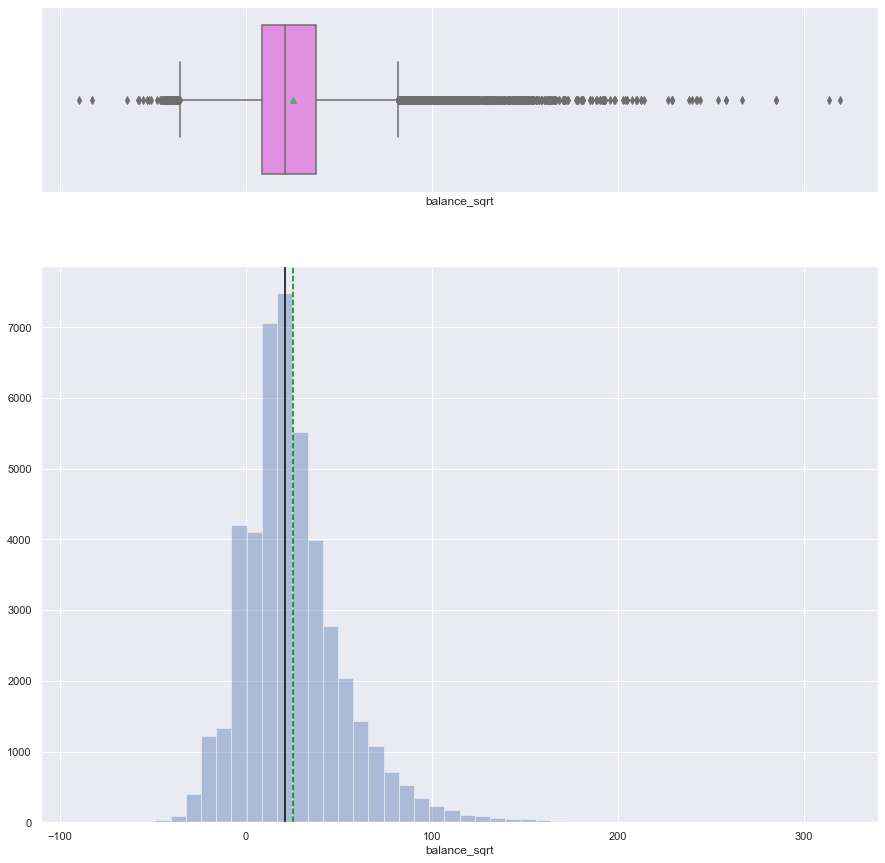

In [254]:
histogram_boxplot(processed_data['balance_sqrt'])

The distribution is much improved.

In [255]:
processed_data.drop('balance', axis=1, inplace=True)

##### day

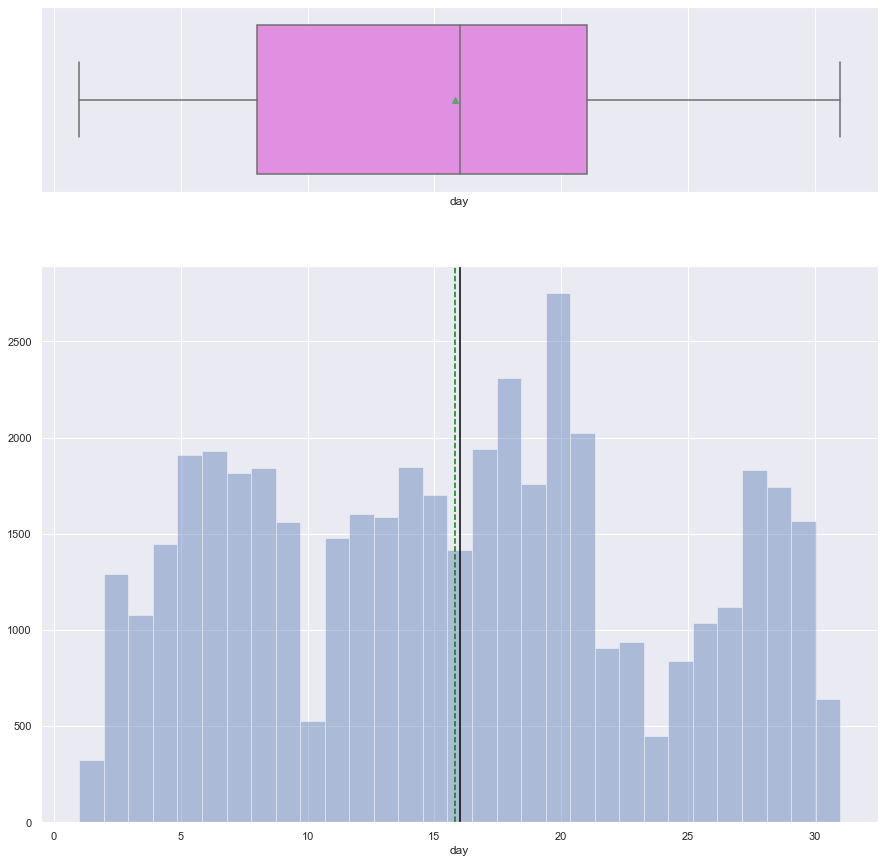

In [256]:
histogram_boxplot(df['day'], bins=31)

`day` does not appear on the data dictionary provided.  It varies between 1 and 31 so it should be a day of the month.  
`day` distribution doesn't appear to have a clear pattern

In [257]:
df['duration'].describe().T

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

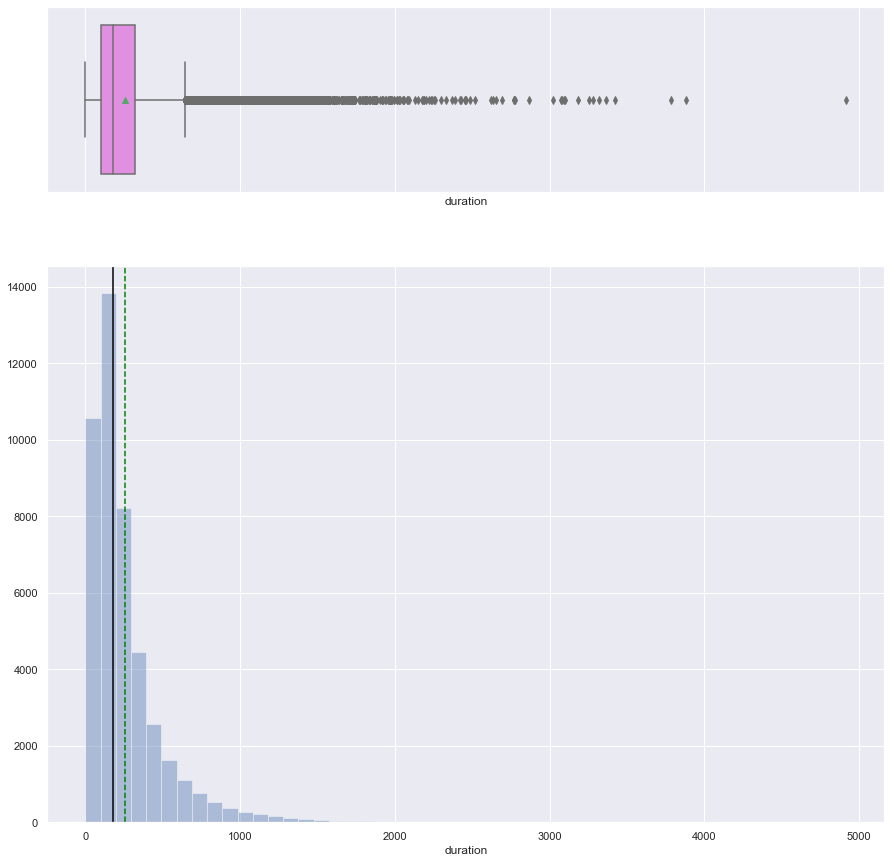

In [258]:
histogram_boxplot(df['duration'])

`duration` is highly skewed to the right.  Some outlier seem very high (more than 3000 secs i.e.  more than 50 minutes).

We will transform with square root.

In [259]:
processed_data['duration_sqrt']=df['duration'].apply(lambda x: m.sqrt(x))

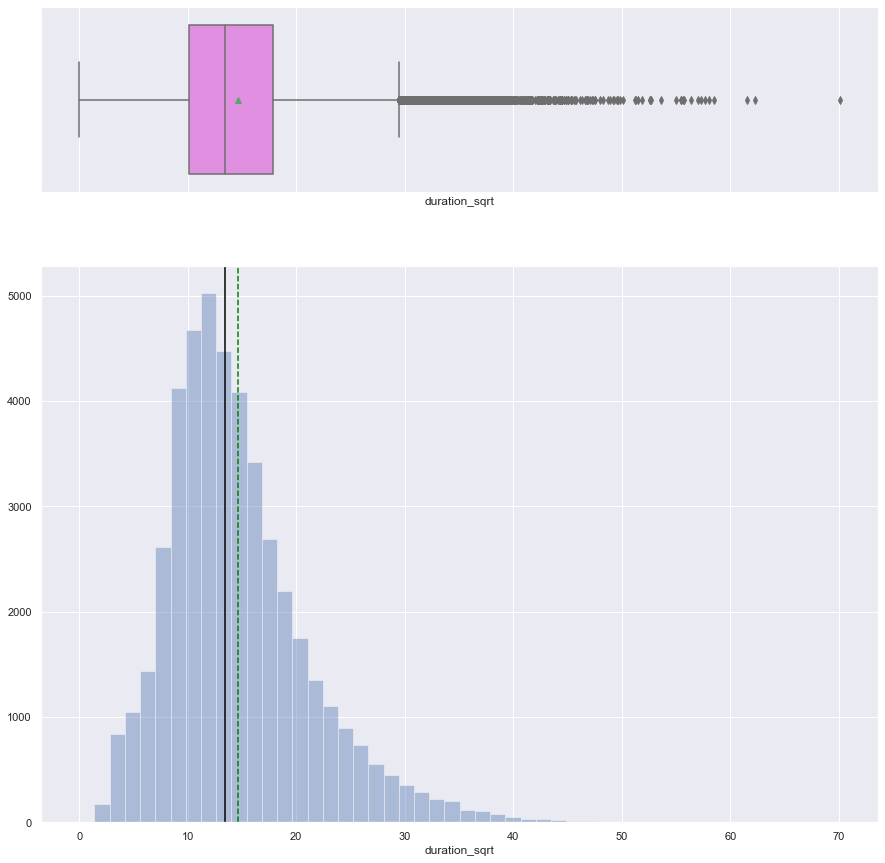

In [260]:
histogram_boxplot(processed_data['duration_sqrt'])

The distribution is improved, although it's still skewed to the right

In [261]:
# drop duration
processed_data.drop('duration', axis=1, inplace=True)

In [262]:
df['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

#### campaign

In [263]:
df['campaign'].value_counts().head(7)

1    17544
2    12505
3     5521
4     3522
5     1764
6     1291
7      735
Name: campaign, dtype: int64

Most values are less than 7

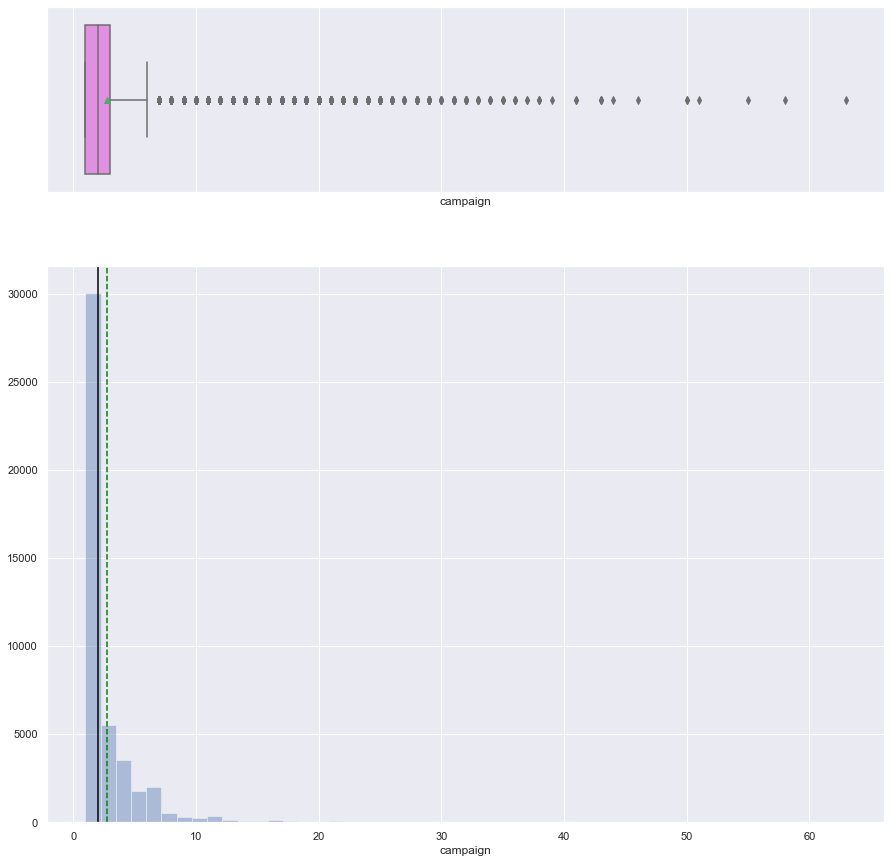

In [264]:
histogram_boxplot(df['campaign'])

`campaign` is highly skewed to the right.  Some value seem very high.
We'll break down by `contact` to see if we can see a pattern

As all values are positive we will transform with log

In [265]:
processed_data['campaign_log'] = processed_data['campaign'].apply(lambda x: m.log(x))

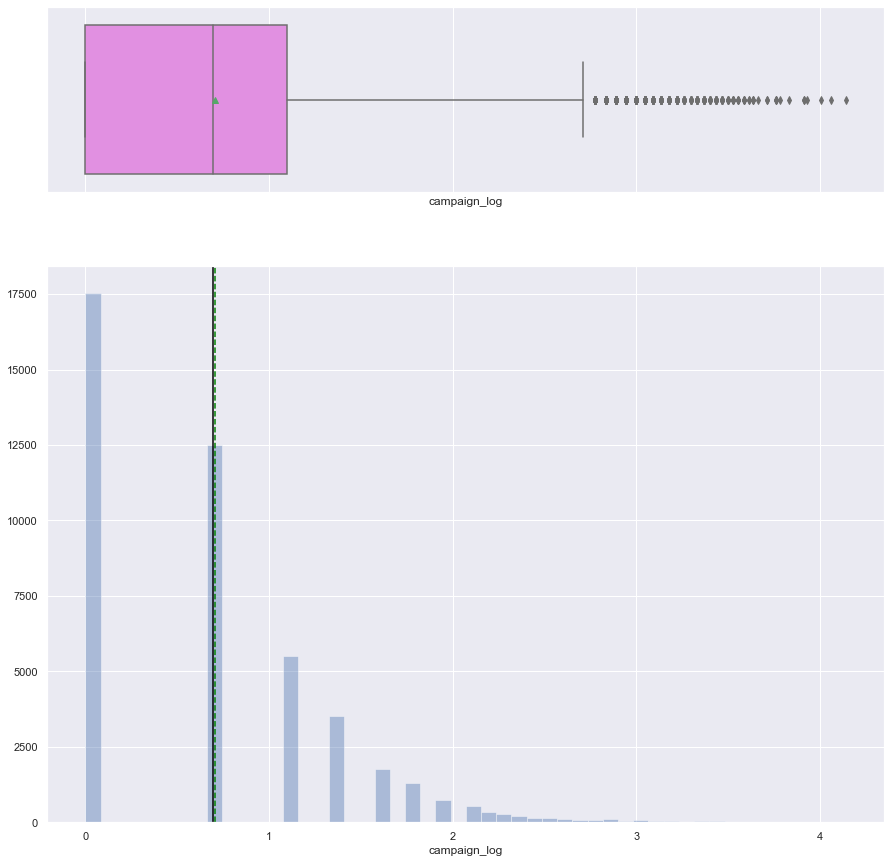

In [266]:
histogram_boxplot(processed_data['campaign_log'])

Distribution is improved but because the majority of values are at the low end of the scale, the distribution remains skewed.

In [267]:
# drop campaign
processed_data.drop('campaign', axis=1, inplace=True)

##### previous

In [268]:
df['previous'].describe()

count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

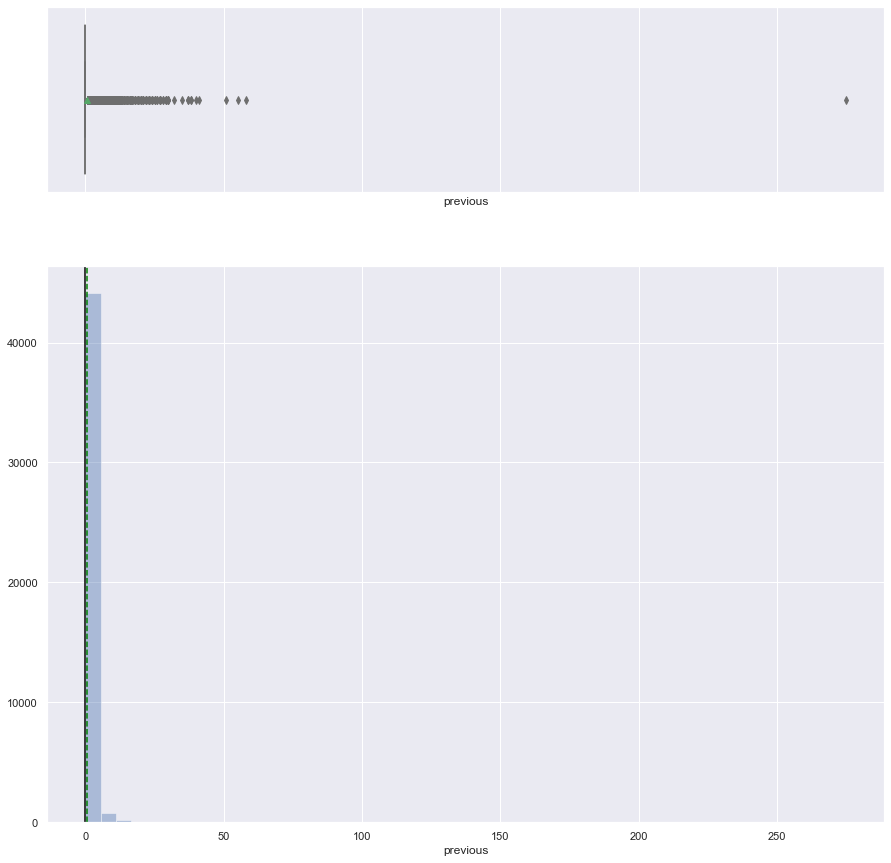

In [269]:
histogram_boxplot(df['previous'])

In [270]:
df['previous'].value_counts().head()

0    36954
1     2772
2     2106
3     1142
4      714
Name: previous, dtype: int64

In [271]:
df['previous'].value_counts().sort_index().tail(10)

32     1
35     1
37     2
38     2
40     1
41     1
51     1
55     1
58     1
275    1
Name: previous, dtype: int64

`previous` is skewed to the right with one outlier with very high number which is probably a data entry error.

Most entries are zero (no contact with this customer before the current campaign)

We will cap the outlier to the nearest value.

In [272]:
previous_cap = df['previous'][df['previous'] < 275].max()
print(f'Second highest number: {previous_cap}')
processed_data['previous'][processed_data['previous'] == 275] = previous_cap

Second highest number: 58


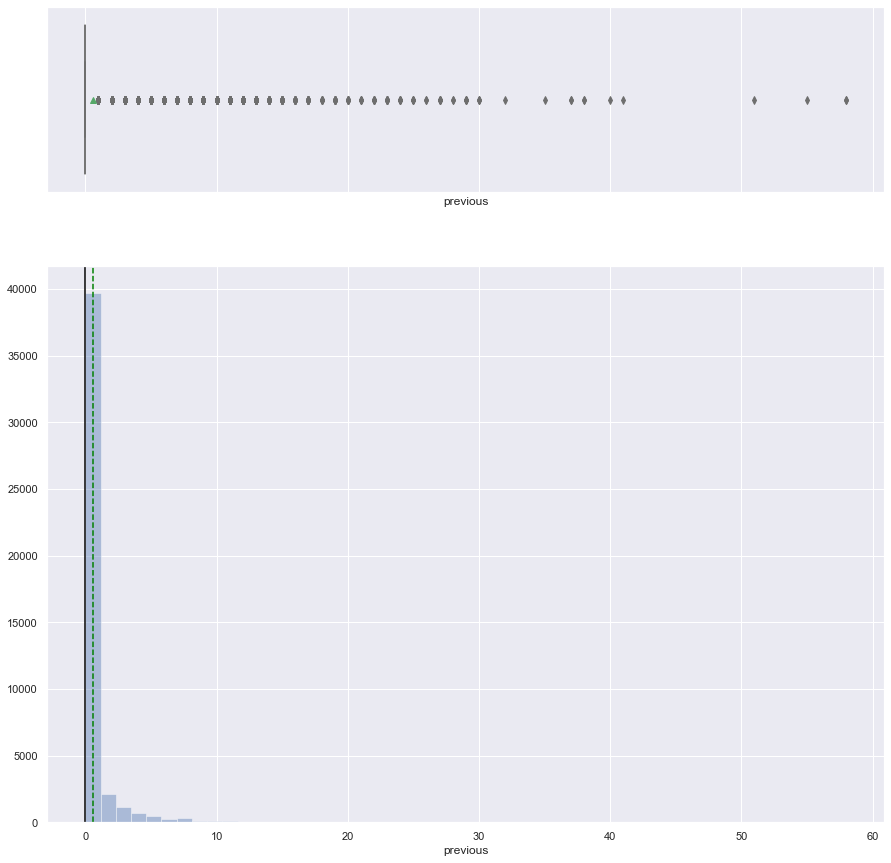

In [273]:
histogram_boxplot(processed_data['previous'])

Previous remains highly skewed.  We will transform with square root.

In [274]:
processed_data['previous_sqrt'] = processed_data['previous'].apply(lambda x: m.sqrt(x))

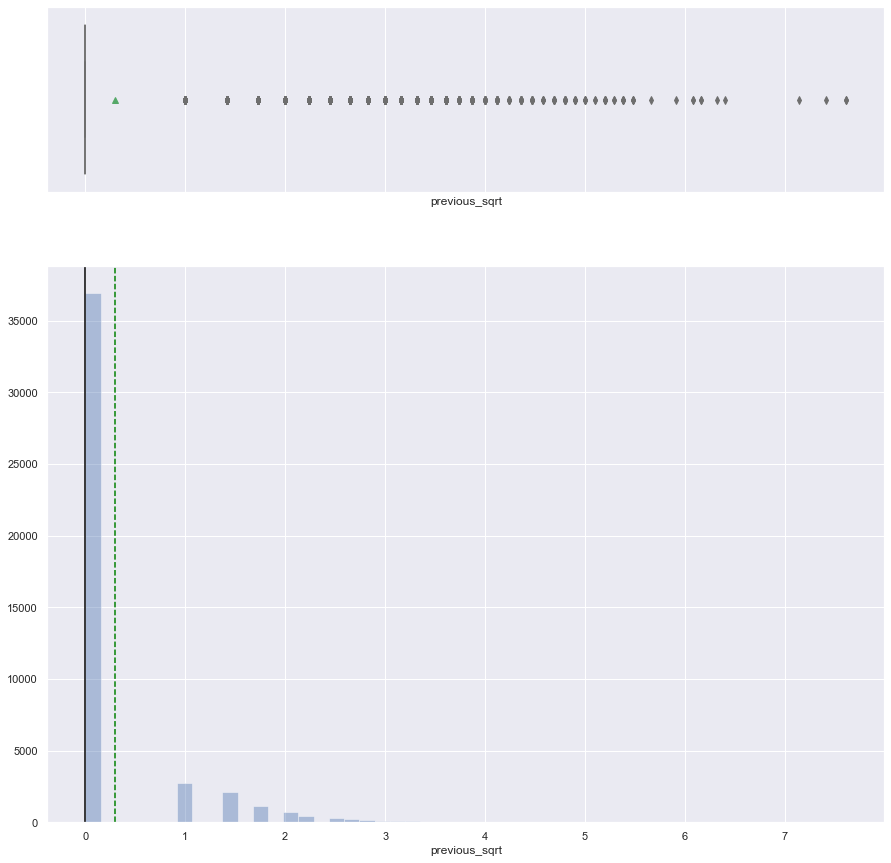

In [275]:
histogram_boxplot(processed_data['previous_sqrt'])

The skew is reduced.  However, since the majority of values are zero a right skew remains

In [276]:
processed_data.drop('previous', axis=1, inplace=True)

##### pdays

In [277]:
df.pdays.describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

In [278]:
df.pdays.value_counts()

-1      36954
 182      167
 92       147
 183      126
 91       126
        ...  
 749        1
 717        1
 589        1
 493        1
 32         1
Name: pdays, Length: 559, dtype: int64

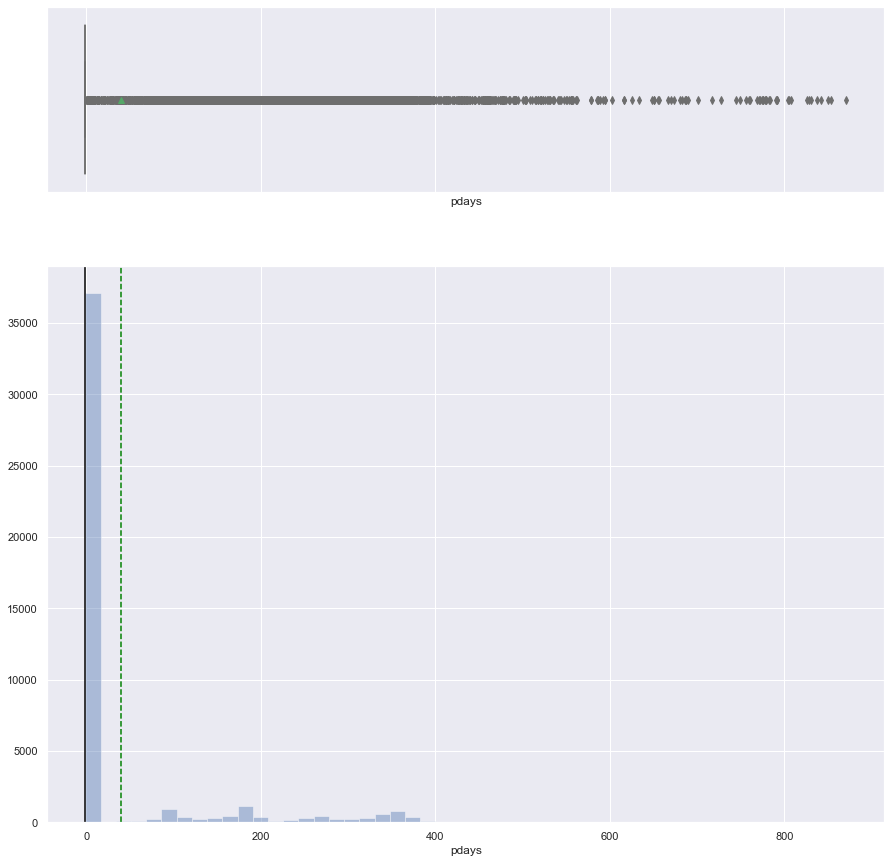

In [279]:
histogram_boxplot(df.pdays)

In [280]:
# count how many pdays == -1
df['pdays'][df['pdays'] == -1].count()

36954

In [281]:
# check what is poutcome when pdays = -1
df[['pdays','poutcome']][df['pdays'] == -1].sample(10)

,pdays,poutcome
13361,-1,unknown
22461,-1,unknown
16225,-1,unknown
26017,-1,unknown
35844,-1,unknown
26018,-1,unknown
43432,-1,unknown
12438,-1,unknown
24070,-1,unknown
6211,-1,unknown


In [282]:
# count how many records have pdays == -1 and poutcome == 'unknown'
df['pdays'][(df['pdays'] == -1)  & (df['poutcome'] == 'unknown')].count()

36954

Majority of customers were not contacted in the previous campaign and have a value of -1 for `pdays`.
All them had `poutcome` = 'unknown'.

We will scale using square root.

In [283]:
processed_data['pdays_sqrt'] = processed_data['pdays'].apply(lambda x: m.sqrt(x) if x >=0 else -m.sqrt(-x)) 

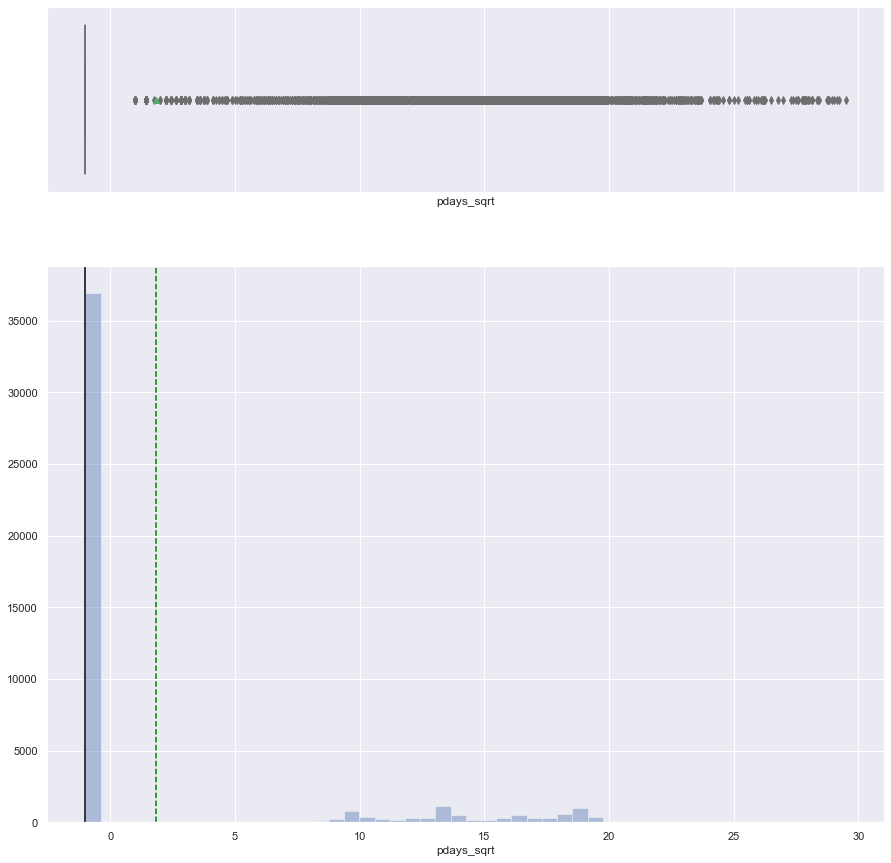

In [284]:
histogram_boxplot(processed_data['pdays_sqrt'])

While the range is now much smaller, the high skew remains as most observation have value of -1.

In [285]:
processed_data.drop('pdays', axis=1, inplace=True)

In [286]:
# view values and counts of categorical variables
cat_columns = df.select_dtypes(include=['category', 'object']).columns.to_list()
for col in cat_columns:
    print(f'Variable = {col}\n----------')
    print(df[col].value_counts(), '\n')

Variable = job
----------
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

Variable = marital
----------
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

Variable = education
----------
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

Variable = default
----------
no     44396
yes      815
Name: default, dtype: int64 

Variable = housing
----------
yes    25130
no     20081
Name: housing, dtype: int64 

Variable = loan
----------
no     37967
yes     7244
Name: loan, dtype: int64 

Variable = contact
----------
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64 

Variable = month
----------
may    13766
jul     6895
aug    

`job` has 12 levels including 288 observation with value of 'unknown'

`marital` has 3 levels, all are appropriate

`education` has 4 levels, including 1857 with value of 'unknown'

`default`, `housing`, `loan` have 2 levels, 'yes' and 'no' as expected

`contact` has 3 level including 13020 observations with value of 'unknown'

`month` has 12 levels as expected

`poutcome` has 4 level.  The majority have value 'unknown' (36959).

`Target` has 2 levels. It is an imbalanced class with majority with a value of 'no' (39922, 86.8%)

In [287]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(z):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(z) # length of the column
    plt.figure(figsize=(15,5))
    ax = sns.countplot(z,palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # height of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percentage 
    plt.show() # show the plot

In [288]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(data, x, y):
    ''' Plot stacked bar charts.
        data = dataframe,
        x = categorical column to plot across x axis
        y = categorical column to stack
    '''
    sns.set()
    ## crosstab 
    tab1 = pd.crosstab(data[x],data[y],margins=True, )
    print(tab1)
    print('-'*120)
    ## visualising the cross tab
    tab = pd.crosstab(data[x],data[y],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(17,7))
    plt.legend(loc='lower left', frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

##### job

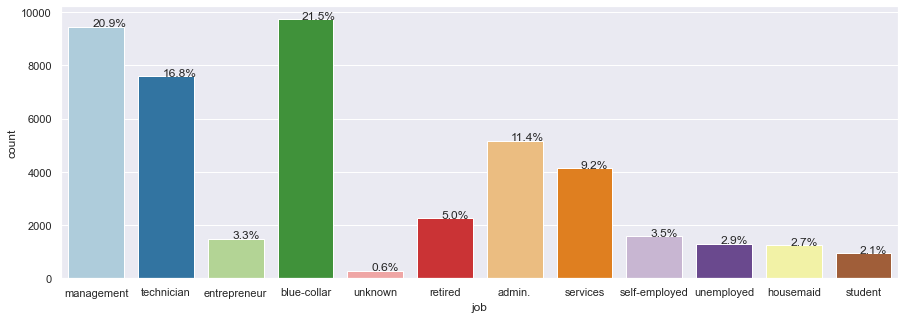

In [289]:
perc_on_bar(df['job'])

`job` has 12 different levels.  The top three levels are 'blue-collar','management' and 'technician' with 22%, 21% and 17% respectively.

##### marital

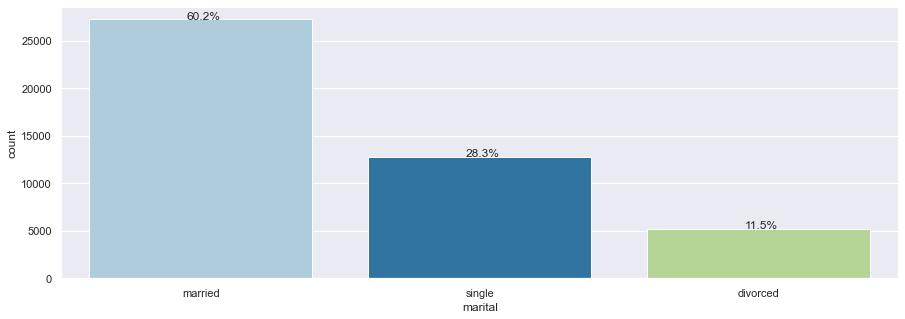

In [290]:
perc_on_bar(df.marital)

Most customers are married with 60%, followed by single and divorced.

##### education

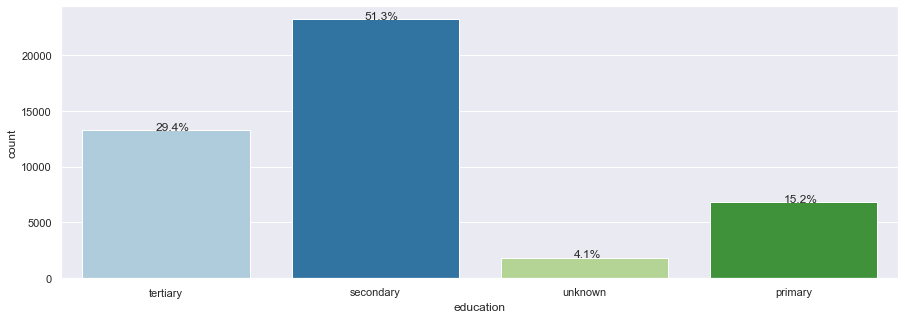

In [291]:
perc_on_bar(df.education)

51% of customers have secondary education followed by tertiary and primary.  For 4% of customer education level is unknown.

##### default

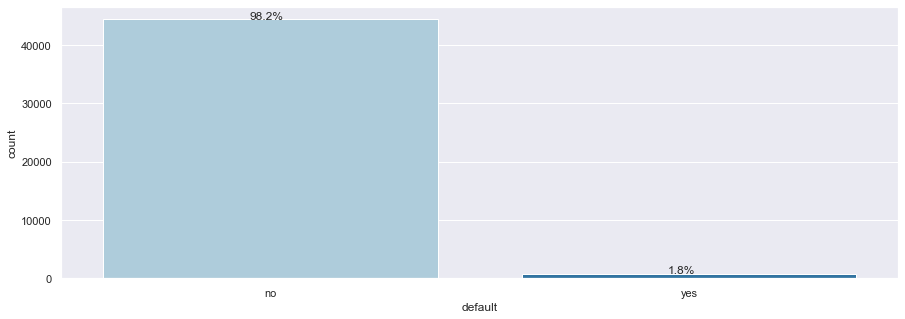

In [292]:
perc_on_bar(df.default)

1.8% of customers have a credit default

##### loan

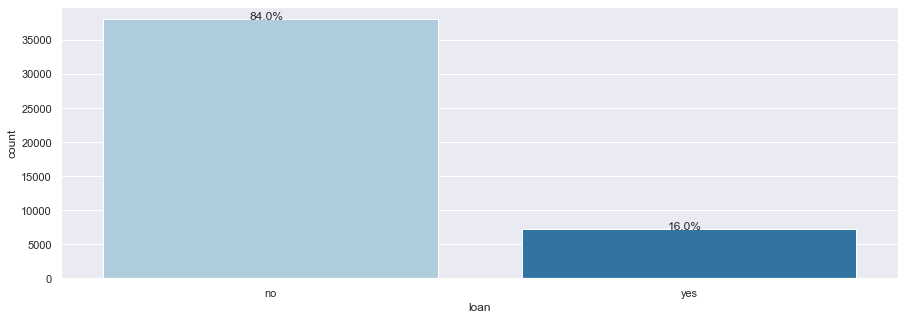

In [293]:
perc_on_bar(df.loan)

16% of customers have a personal loan

In [294]:
##### housing

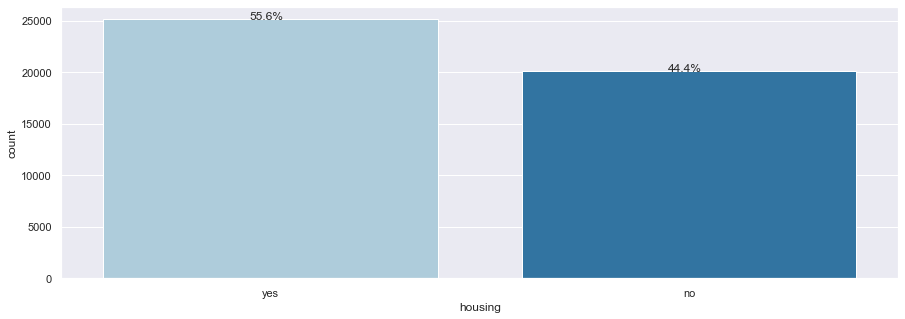

In [295]:
perc_on_bar(df.housing)

56% of customers have a housing loan

##### contact

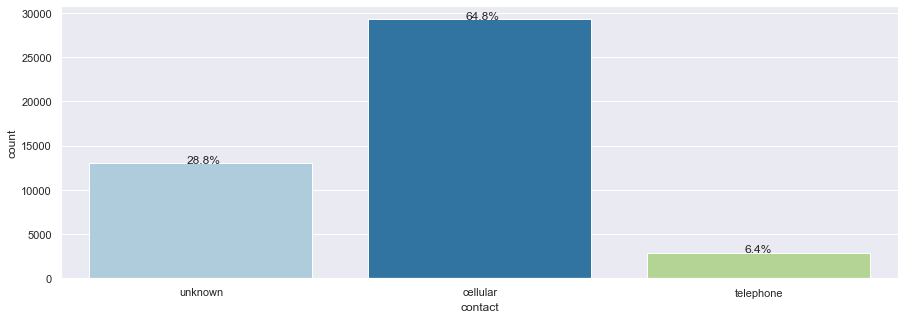

In [296]:
perc_on_bar(df.contact)

Most customers (65%) are reached via a cellular phone. Only 6.4% are contacted using a phone.

There is a high percentage with value 'unknown'

##### month

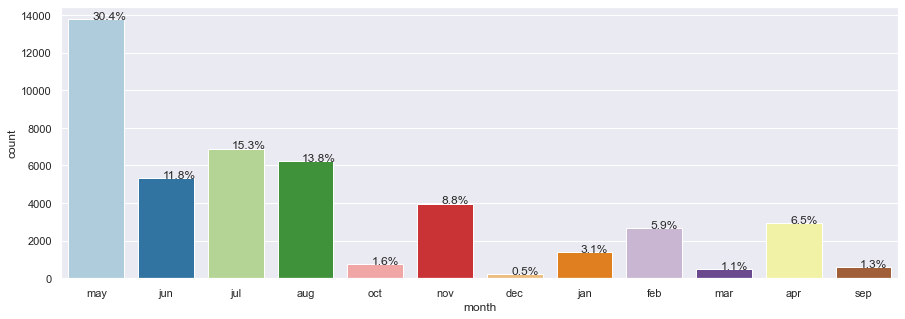

In [297]:
perc_on_bar(df.month)

<AxesSubplot:xlabel='month', ylabel='count'>

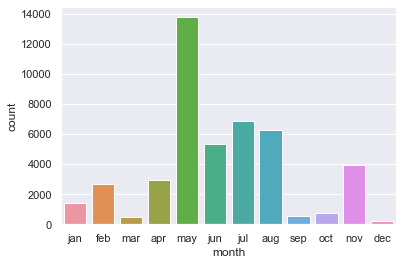

In [298]:
# plot month in order, starting from 'jan'
months_ordered = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
sns.countplot(df.month, order=months_ordered)

30% of customers were contacted last in May.  

June (12%), July (15%), August (14%) represent the next highest percentages, suggesting most of the current campaign was run between May and August.

##### poutcome

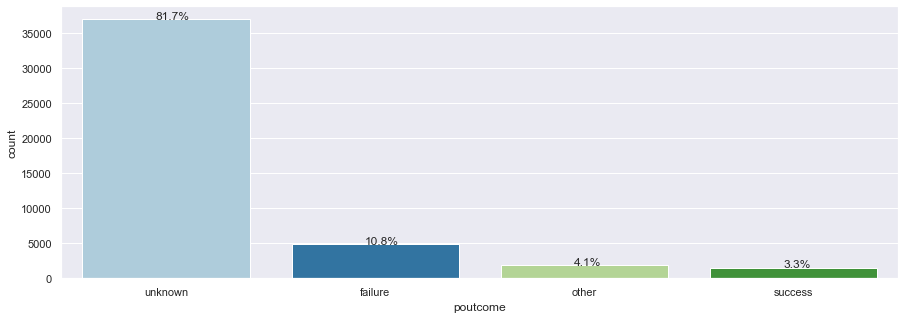

In [299]:
perc_on_bar(df.poutcome)

Most values of `poutcome` are 'unknown'.

##### Target

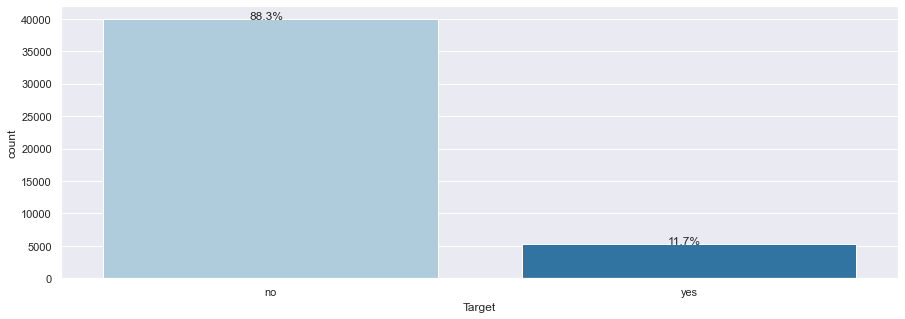

In [300]:
perc_on_bar(df.Target)

`Target` is an imbalanced class.  12% percent of customers have a term deposit.

Convert object type columns to category

### By-variate analysis

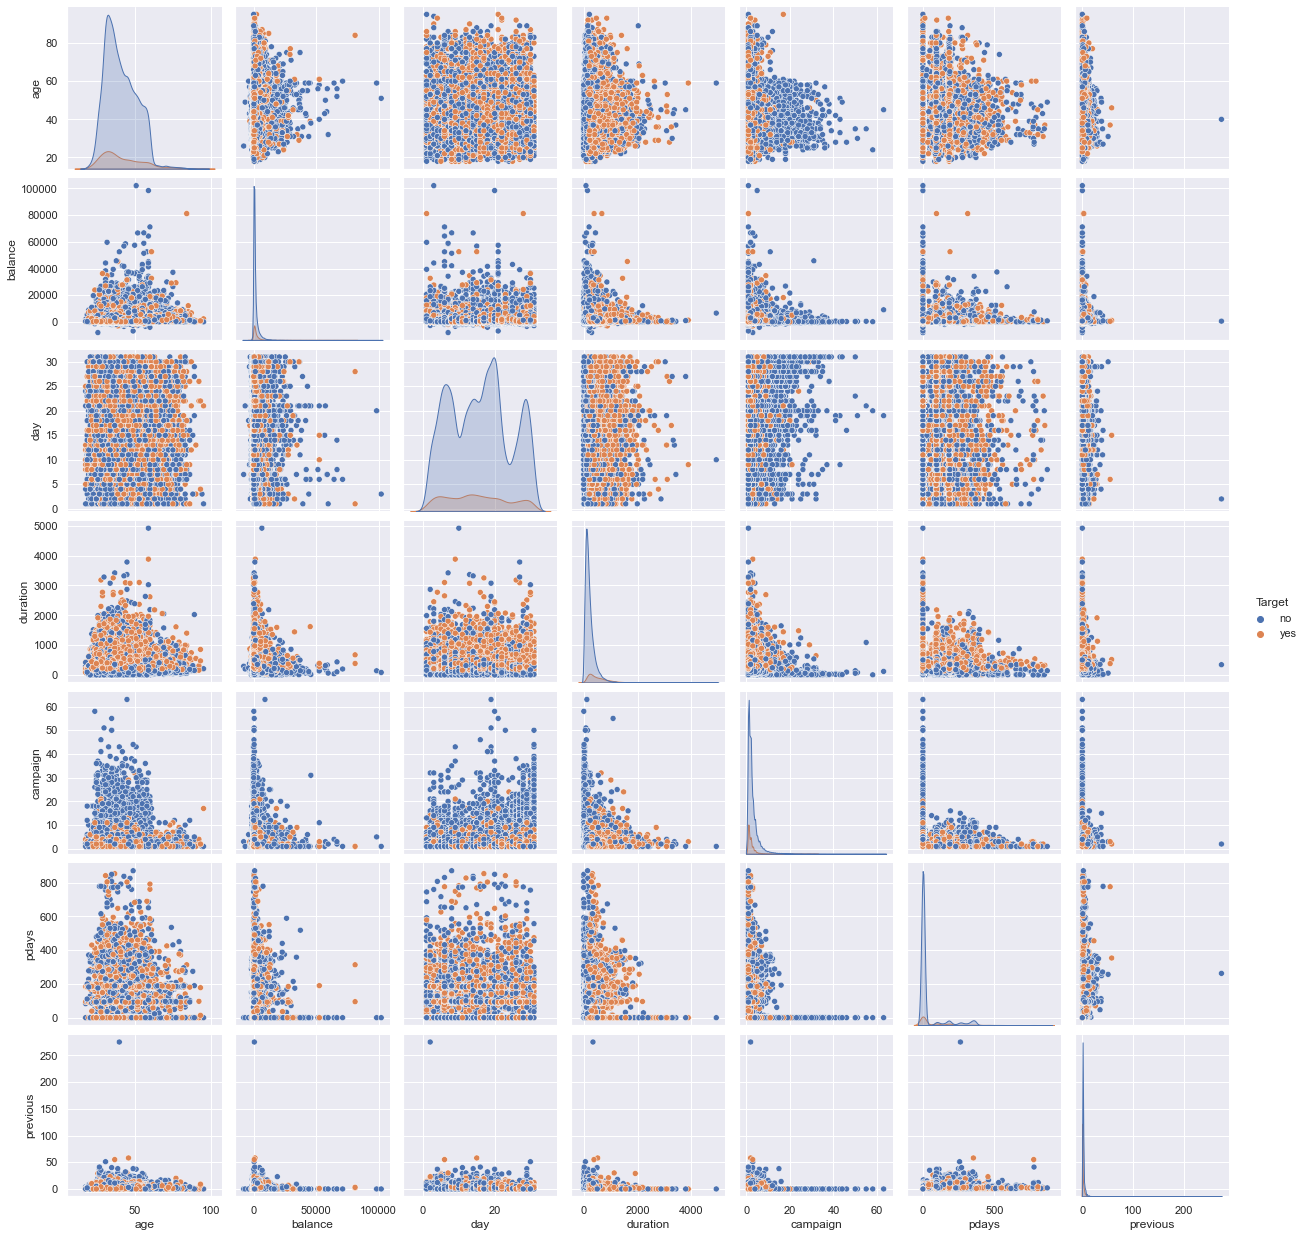

In [301]:
# plot pairs
sns.pairplot(df, hue='Target')

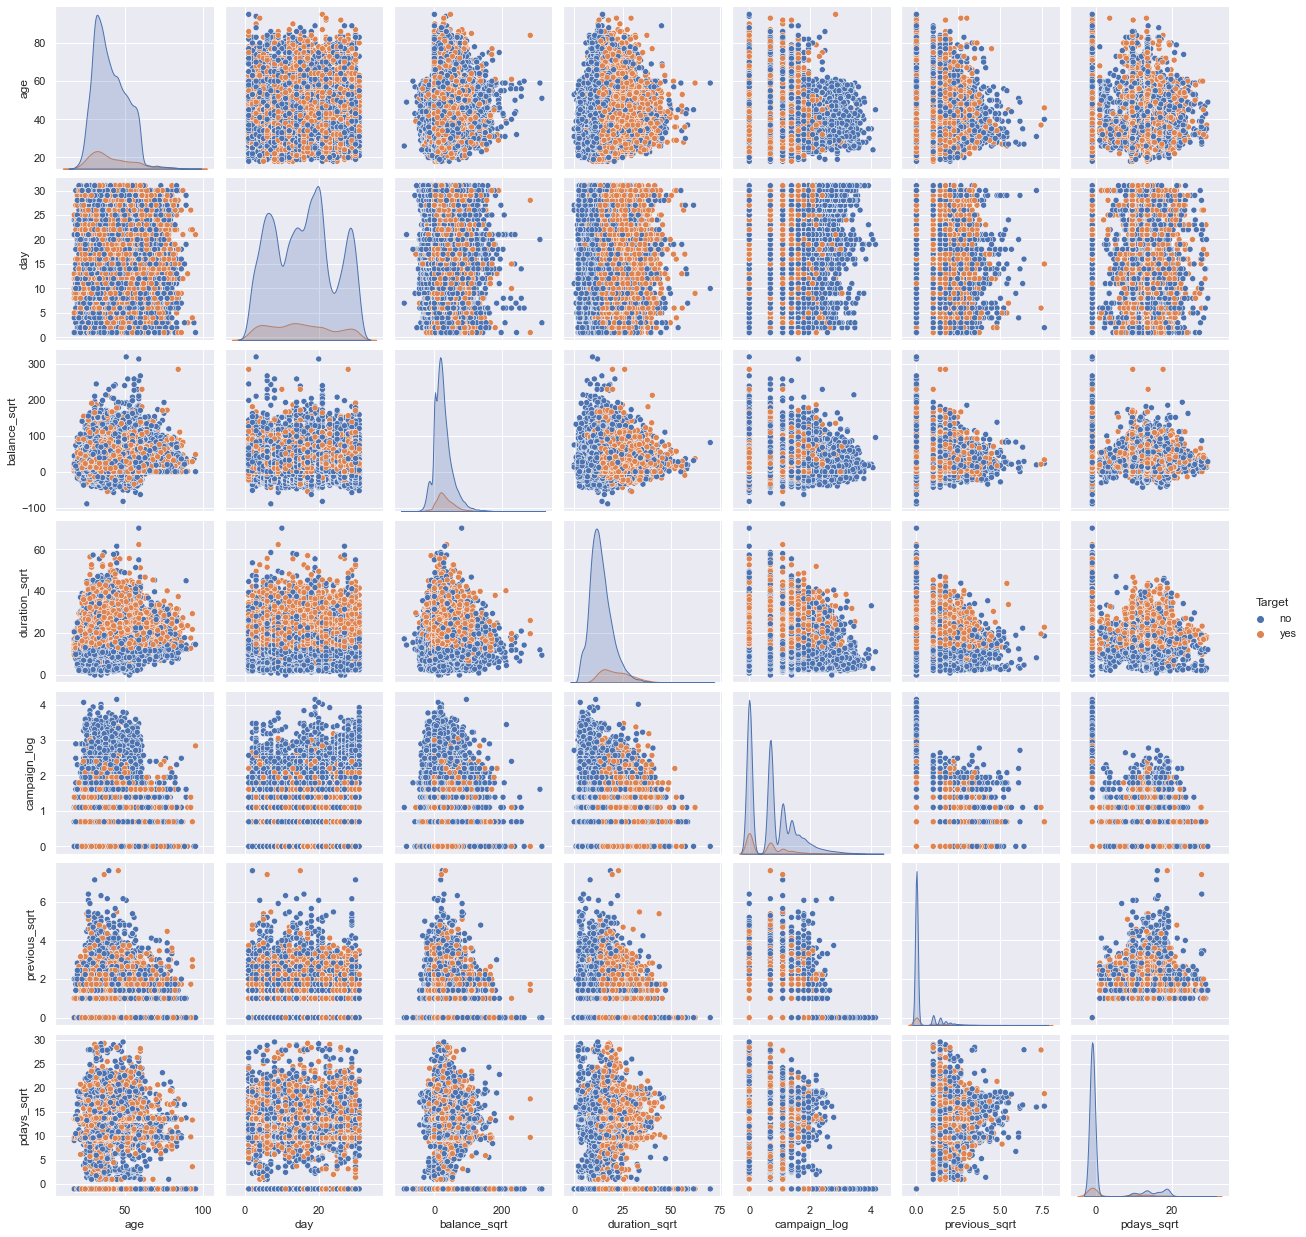

In [302]:
sns.pairplot(processed_data, hue='Target')

### Pair plot observations

* Distribution of age is similar for customers with and without term deposit.  Age might not be a good predictor for `Target`
* Distribution of day is similar for customers with and without term deposit.  `day` might not be a good predictor for `Target`
* Customers with a lower number for `campaign` (number of contacts in the current campaign) have more term deposits.  
    However, this might be due to the fact that customers who already have a term deposit are not targeted in the current campaign.
* Higher values of `duration_trsfrm` are observed for customer with term deposit.

<AxesSubplot:xlabel='Target', ylabel='campaign'>

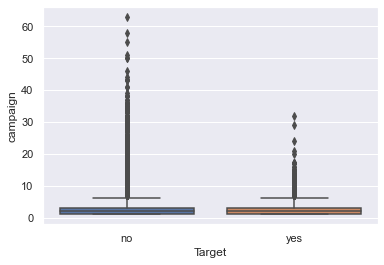

In [303]:
sns.boxplot(y='campaign',x='Target', data=df)

<AxesSubplot:xlabel='Target', ylabel='campaign_log'>

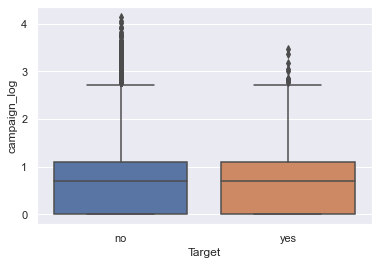

In [304]:
sns.boxplot(y='campaign_log',x='Target', data=processed_data)

Customers with term deposit tend to have a smaller range of `campaign` with less outliers

<AxesSubplot:xlabel='Target', ylabel='duration_sqrt'>

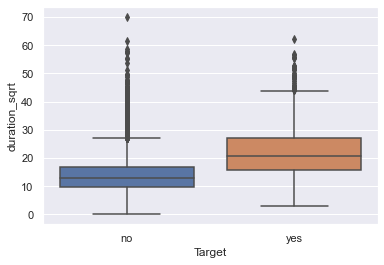

In [305]:
sns.boxplot(y='duration_sqrt',x='Target', data=processed_data)

`duration` is a good predictor of `Target`

However, we will not have a value for `duration` at prediction time, as this will be known only _after_ the customer has been contacted for the next campaign.

We will drop duration.

In [306]:
processed_data.drop('duration_sqrt', axis=1, inplace=True)

In [307]:
# check columns
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            45211 non-null  int64  
 1   job            45211 non-null  object 
 2   marital        45211 non-null  object 
 3   education      45211 non-null  object 
 4   default        45211 non-null  object 
 5   housing        45211 non-null  object 
 6   loan           45211 non-null  object 
 7   contact        45211 non-null  object 
 8   day            45211 non-null  int64  
 9   month          45211 non-null  object 
 10  poutcome       45211 non-null  object 
 11  Target         45211 non-null  object 
 12  balance_sqrt   45211 non-null  float64
 13  campaign_log   45211 non-null  float64
 14  previous_sqrt  45211 non-null  float64
 15  pdays_sqrt     45211 non-null  float64
dtypes: float64(4), int64(2), object(10)
memory usage: 5.5+ MB


Target     no   yes    All
day                       
1         232    90    322
2        1111   182   1293
3         901   178   1079
4        1215   230   1445
5        1695   215   1910
6        1751   181   1932
7        1660   157   1817
8        1641   201   1842
9        1382   179   1561
10        403   121    524
11       1298   181   1479
12       1359   244   1603
13       1344   241   1585
14       1638   210   1848
15       1465   238   1703
16       1223   192   1415
17       1763   176   1939
18       2080   228   2308
19       1635   122   1757
20       2560   192   2752
21       1825   201   2026
22        751   154    905
23        813   126    939
24        385    62    447
25        707   133    840
26        919   116   1035
27        971   150   1121
28       1687   143   1830
29       1616   129   1745
30       1295   271   1566
31        597    46    643
All     39922  5289  45211
----------------------------------------------------------------------------------

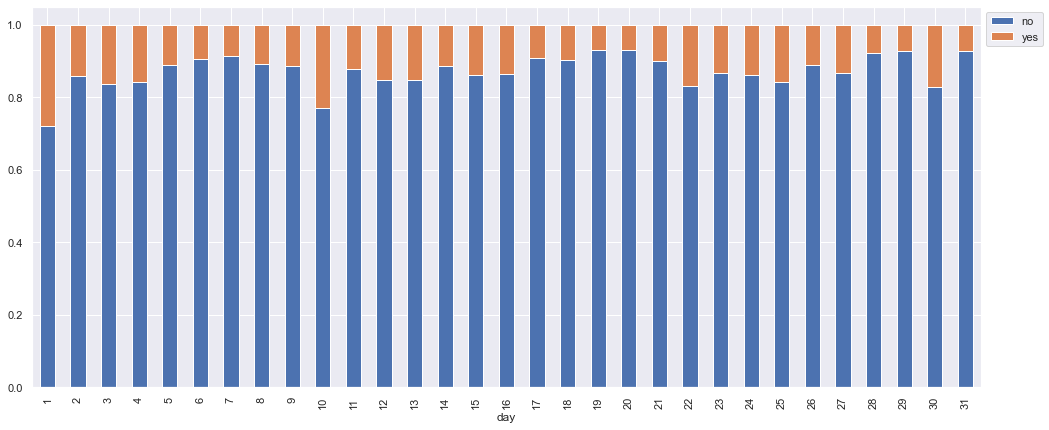

In [308]:
stacked_plot(x='day',y='Target', data=df)

Although some days have higher rates of deposit term than others, there is no clear pattern.

### Correlations

In [309]:
##### Original data

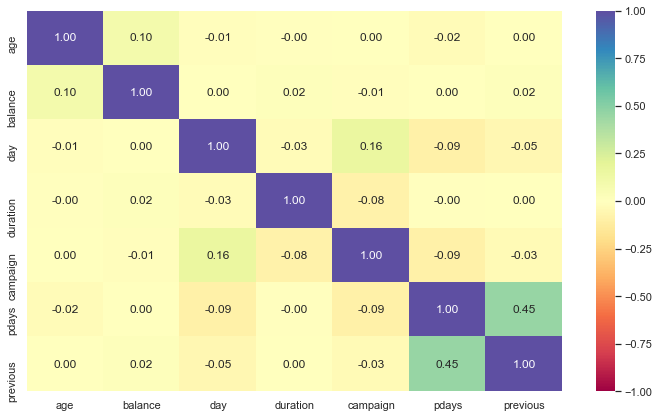

In [310]:
# plot correlation matrix for original data
plt.figure(figsize=(12, 7))
sns.heatmap(
    df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

##### Data after transformation

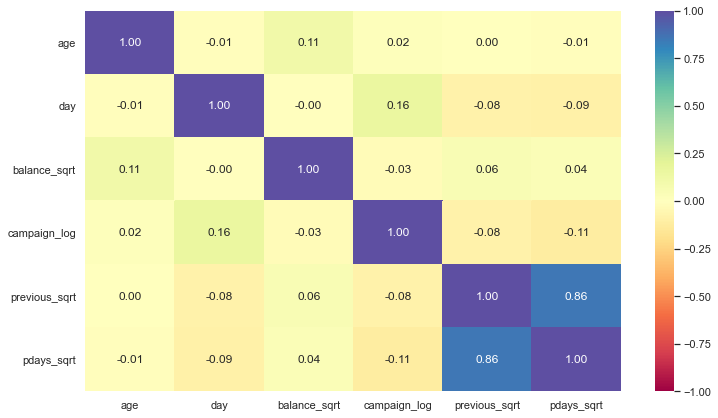

In [311]:
plt.figure(figsize=(12, 7))
sns.heatmap(
    processed_data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Correlation observations
* There is a weak correlation between `campaign` and `day`
* There is a positive correlation between `previous` and `pdays`
* Most other variables show no correlation

Change categorical variables to category dtype

We'll leave `day` as numeric as we don't want to create one column for each day using dummy variables.

In [312]:
for column in cat_columns:
    processed_data[column] = processed_data[column].astype('category')
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            45211 non-null  int64   
 1   job            45211 non-null  category
 2   marital        45211 non-null  category
 3   education      45211 non-null  category
 4   default        45211 non-null  category
 5   housing        45211 non-null  category
 6   loan           45211 non-null  category
 7   contact        45211 non-null  category
 8   day            45211 non-null  int64   
 9   month          45211 non-null  category
 10  poutcome       45211 non-null  category
 11  Target         45211 non-null  category
 12  balance_sqrt   45211 non-null  float64 
 13  campaign_log   45211 non-null  float64 
 14  previous_sqrt  45211 non-null  float64 
 15  pdays_sqrt     45211 non-null  float64 
dtypes: category(10), float64(4), int64(2)
memory usage: 2.5 MB


In [313]:
### By-variate analysis with categorical variables

##### Job vs Target

Target            no   yes    All
job                              
admin.          4540   631   5171
blue-collar     9024   708   9732
entrepreneur    1364   123   1487
housemaid       1131   109   1240
management      8157  1301   9458
retired         1748   516   2264
self-employed   1392   187   1579
services        3785   369   4154
student          669   269    938
technician      6757   840   7597
unemployed      1101   202   1303
unknown          254    34    288
All            39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


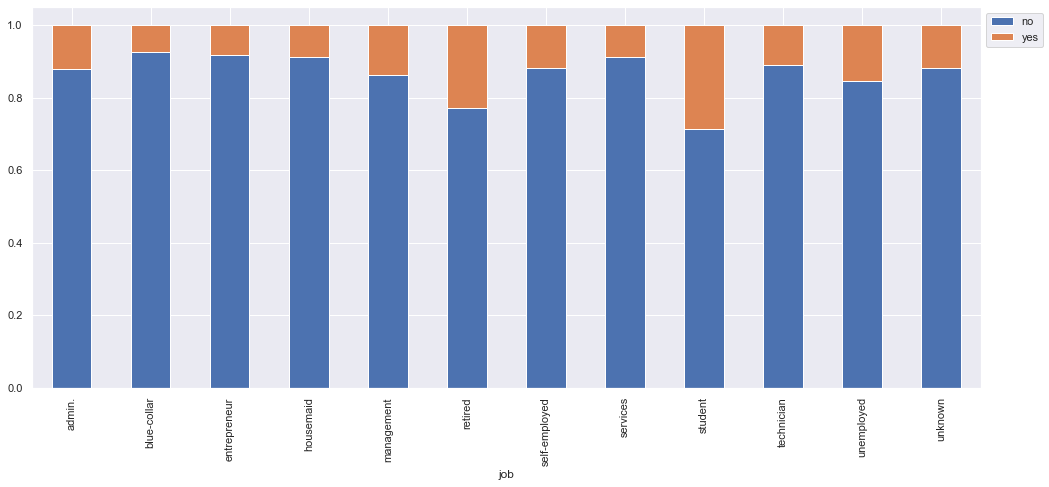

In [314]:
stacked_plot(processed_data, 'job','Target')

Customers with `job` of 'retired' or 'student' tend to have higher rates of term deposits.

Customers with `job` of 'management' have the highest absolute number of term deposits.

##### marital vs Target

Target       no   yes    All
marital                     
divorced   4585   622   5207
married   24459  2755  27214
single    10878  1912  12790
All       39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


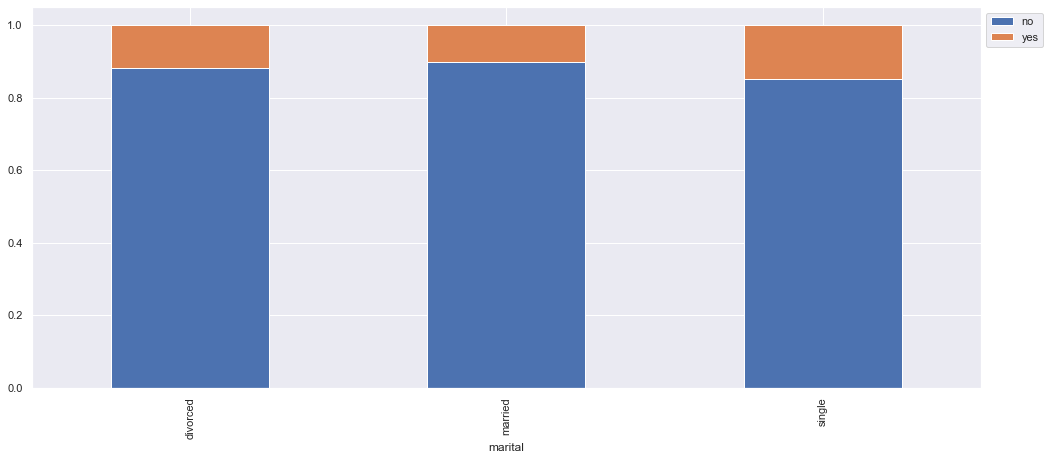

In [315]:
stacked_plot(processed_data, 'marital','Target')

Customers who are single have a higher rate of term deposit, followed by divorced and lastly married

In [316]:
##### education vs Target

Target        no   yes    All
education                    
primary     6260   591   6851
secondary  20752  2450  23202
tertiary   11305  1996  13301
unknown     1605   252   1857
All        39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


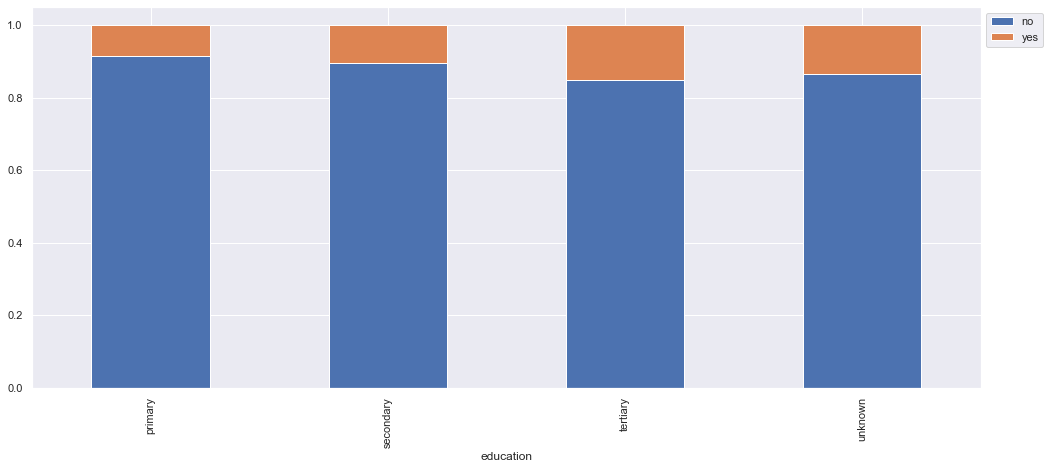

In [317]:
stacked_plot(processed_data, 'education','Target')

Customers with tertiary education have higher rates of term deposit than others.

##### default vs Target

Target      no   yes    All
default                    
no       39159  5237  44396
yes        763    52    815
All      39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


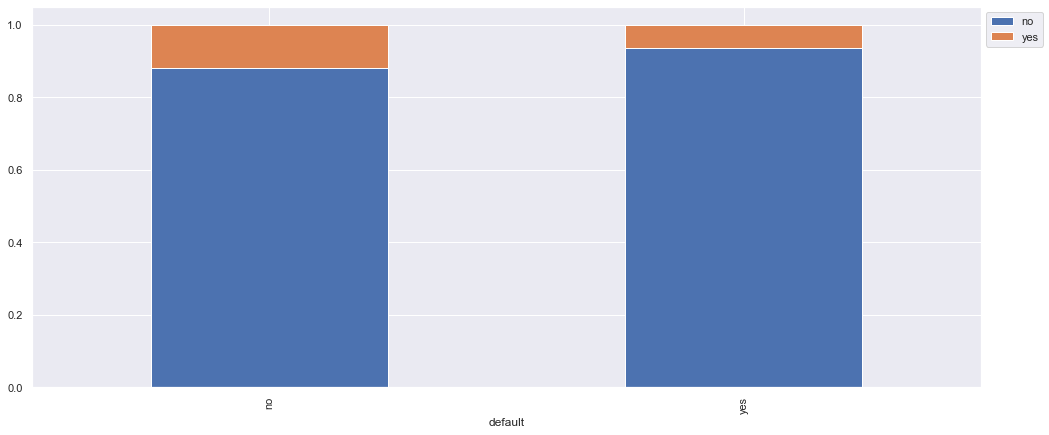

In [318]:
stacked_plot(processed_data, 'default','Target')

Customers with no credit default have higher rates of term deposits

##### housing vs Target

Target      no   yes    All
housing                    
no       16727  3354  20081
yes      23195  1935  25130
All      39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


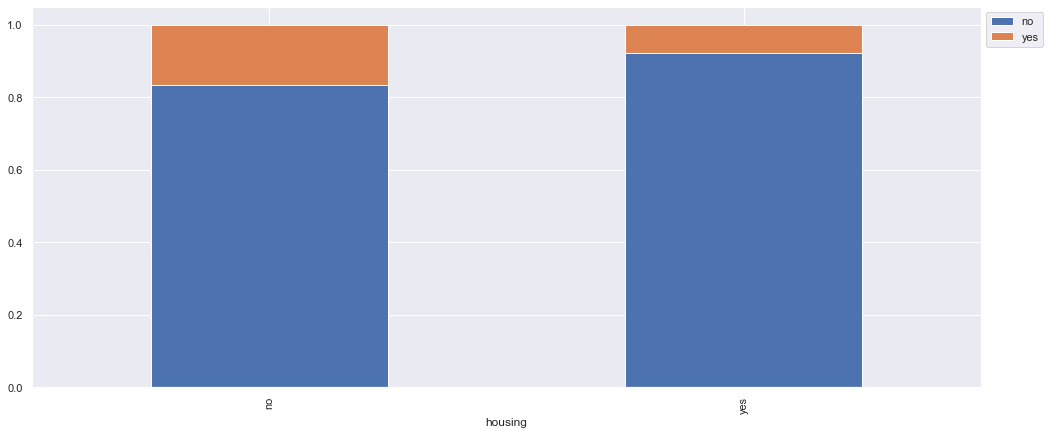

In [319]:
stacked_plot(processed_data, 'housing','Target')

Customers without a housing loan have higher rates of term deposits.

In [320]:
##### loan vs Target

Target     no   yes    All
loan                      
no      33162  4805  37967
yes      6760   484   7244
All     39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


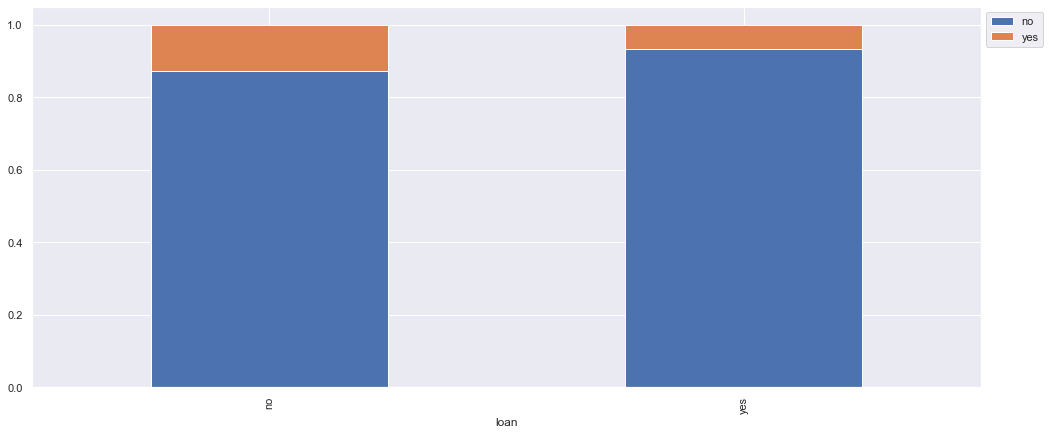

In [321]:
stacked_plot(processed_data, 'loan','Target')

Customers without a personal loan have higher rates of term deposit.

##### contact vs Target

Target        no   yes    All
contact                      
cellular   24916  4369  29285
telephone   2516   390   2906
unknown    12490   530  13020
All        39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


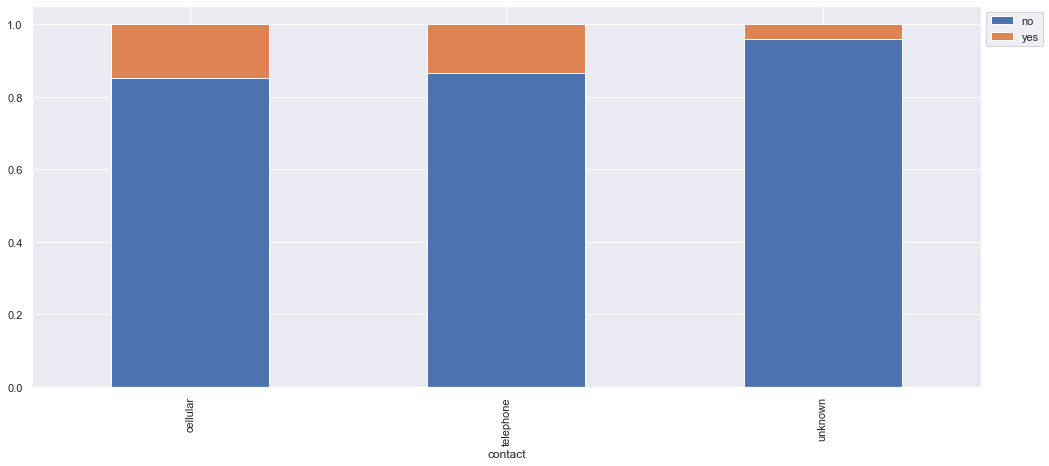

In [322]:
stacked_plot(processed_data, 'contact','Target')

Customers with `contact` of 'cellular' and 'telephone' have similar rates of term deposit.  'unknown' has lowest rate.

##### month vs Target

Target     no   yes    All
month                     
apr      2355   577   2932
aug      5559   688   6247
dec       114   100    214
feb      2208   441   2649
jan      1261   142   1403
jul      6268   627   6895
jun      4795   546   5341
mar       229   248    477
may     12841   925  13766
nov      3567   403   3970
oct       415   323    738
sep       310   269    579
All     39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


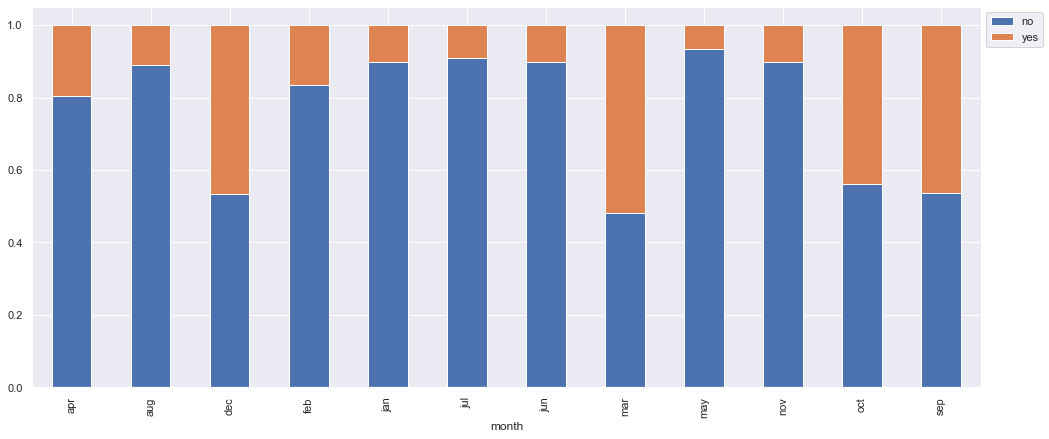

In [323]:
stacked_plot(processed_data, 'month','Target')

Customers who have last contact `month` of 'dec', 'mar', 'oct' and 'sep' have significantly higher rates of term deposits.

##### poutcome vs Target

Target       no   yes    All
poutcome                    
failure    4283   618   4901
other      1533   307   1840
success     533   978   1511
unknown   33573  3386  36959
All       39922  5289  45211
------------------------------------------------------------------------------------------------------------------------


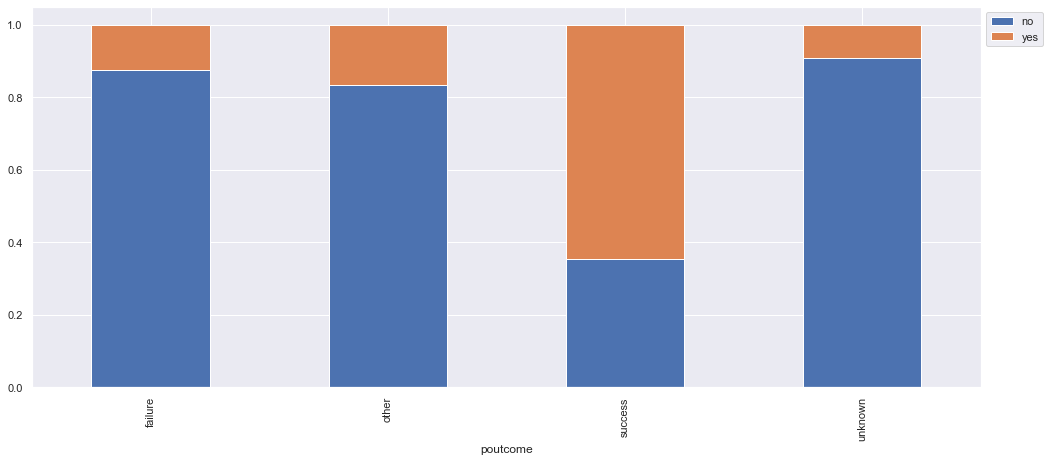

In [324]:
stacked_plot(processed_data, 'poutcome','Target')

Customers with `poutcome` of 'success' have a significantly higher rate of term deposit.

### EDA Summary

* `age` ranges from 18 to 95, it is skewed to the right with a number of outlier.  Outliers seem to be legitimate.

* `balance` ranges from -8091 to 102127.  It is highly skewed to the right with a large number of outlier.  
    3766 customers have negative balance.
    Because of the high skew, it was transformed using sklearn.PowerTransformer().
    After transformation, two major outlier still existed which were dropped.
* `day_of_week` is listed in the provided data dictionary but doesn't appear in the data set.  Instead we have `day`.  
    `day` ranges between 1 and 31, so it appears to be a day of the month.  
    Its distribution doesn't appear to have a clear pattern.
* `duration` is highly skewed to the right.  
    Some outlier seem very high (3000+ secs ~ 50+ minutes).  
    However, as `duration` will not be available at prediction time, the column was dropped for prediction purposes.
* `campaign` ranges between 1 and 63.  It's highly skewed to the right.
* `previous` is skewed to the right with one outlier with very high number which is probably a data entry error.  
    Most entries are zero (no contact with this customer before the current campaign).
    The one major outlier was capped to the nearest value.
* `pdays`: the majority of customers were not contacted in the previous campaign and have a value of -1 (36+K, ~80%)

* `job` has twelve levels including 288 observation with value of 'unknown'.  
    The top three levels are 'blue-collar','management' and 'technician' with 22%, 21% and 17% respectively.

* `marital` has three levels, 'married', 'single' and 'divorced'.  
    Most customers are married (60%), followed by single and divorced.

* `education` has four levels, including 1857 with value of 'unknown' (4%).  
    51% of customers have secondary education followed by tertiary and primary.

* `default` has two levels, 'yes' and 'no'.  
    1.8% of customers have a credit default
* `loan` has two levels, 'yes' and 'no'.  
    16% of customers have a personal loan.
* `housing` has two levels, 'yes' and 'no'.  
    56% of customers have a housing loan.

* `contact` has three levels including 13020 observations (29%) with value of 'unknown'.  
    Most customers (65%) are reached via a cellular phone. Only 6.4% are contacted using a phone.
    
* `month` has twelve levels.  
    30% of customers were contacted last in May.  June (12%), July (15%), August (14%) represent the next highest percentages, suggesting most of the current campaign was run between May and August.
    
* `poutcome` has four levels, 'unknown', 'failure', 'success' and 'other'. The majority have value 'unknown' (36959).  
    As almost all observations with 'unknown' have also `pdays` = -1.  Meaning customers who were not contacted in the previous campaign were assigned 'unknown'.

* `Target` has 2 levels. It is an imbalanced class with majority with a value of 'no' (39922, 86.8%)

#### By-variate EDA Summary

* `age vs Target`: distribution of age is similar for customers with and without term deposit.  Age might not be a good predictor for `Target`
* `day vs Target`: distribution of day is similar for customers with and without term deposit.  `day` might not be a good predictor for `Target`
* `campaign vs Target`: customers with a lower number for `campaign` (number of contacts in the current campaign) have more term deposits.  
    Also the range of `campaign` for Target = 'yes' is smaller than 'no' (max campaign of 65 vs 35)
    However, this might be due to the fact that customers who already have a term deposit are not targeted in the current campaign.
* `duration vs Target`: higher values of `duration` are observed for customer with term deposit.
* `job vs Target`: Customers with job of 'retired' or 'student' tend to have higher rates of term deposits.  
    Customers with job of 'management' have the highest absolute number of term deposits.
* `marital vs Target`: Customers who are single have a higher rate of term deposit, followed by divorced and lastly married.
* `education vs Target`: Customers with tertiary education have higher rates of term deposit than others.
* `default vs Target`: Customers with no credit default have higher rates of term deposits
* `housing vs Target`: Customers without a housing loan have higher rates of term deposits.
* `loan vs Target`: Customers without a personal loan have higher rates of term deposit.
* `contact vs Target`: Customers with contact of 'cellular' and 'telephone' have similar rates of term deposit. 'unknown' has lowest rate.
* `month vs Target`: Customers who have last contact `month` of 'dec', 'mar', 'oct' and 'sep' have significantly higher rates of term deposits.
* `poutcome vs Target`: Customers with poutcome of 'success' have a significantly higher rate of term deposit.

#### Data preparation prior to model building

In [325]:
# extract dependent and independent vars
X = processed_data.drop(columns='Target')
Y = processed_data['Target']

In [326]:
Y.value_counts()

no     39922
yes     5289
Name: Target, dtype: int64

In [327]:
processed_data.dtypes

age                 int64
job              category
marital          category
education        category
default          category
housing          category
loan             category
contact          category
day                 int64
month            category
poutcome         category
Target           category
balance_sqrt      float64
campaign_log      float64
previous_sqrt     float64
pdays_sqrt        float64
dtype: object

In [328]:
# get dummy variables
X = pd.get_dummies(X, drop_first=True)

# transform Target into numeric
Y = Y.apply(lambda x: 1 if x =='yes' else 0)

In [329]:
Y.value_counts()

0    39922
1     5289
Name: Target, dtype: int64

In [330]:
# # encode month
# months_codes = dict(zip(months_ordered, range(12)))
# X['month_enc'] = X['month'].apply(lambda x: months_codes[x]).astype('uint8')
# X.drop('month', axis=1, inplace=True)

In [331]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  int64  
 1   day                  45211 non-null  int64  
 2   balance_sqrt         45211 non-null  float64
 3   campaign_log         45211 non-null  float64
 4   previous_sqrt        45211 non-null  float64
 5   pdays_sqrt           45211 non-null  float64
 6   job_blue-collar      45211 non-null  uint8  
 7   job_entrepreneur     45211 non-null  uint8  
 8   job_housemaid        45211 non-null  uint8  
 9   job_management       45211 non-null  uint8  
 10  job_retired          45211 non-null  uint8  
 11  job_self-employed    45211 non-null  uint8  
 12  job_services         45211 non-null  uint8  
 13  job_student          45211 non-null  uint8  
 14  job_technician       45211 non-null  uint8  
 15  job_unemployed       45211 non-null 

#### split into test and train

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(f'Percent Target Train= 1: {100 * y_train[y_train==1].count()/len(y_train)}')
print(f'Percent Target Test = 1: {100 * y_test[y_test==1].count()/len(y_test)}')

(31647, 41) (13564, 41)
(31647,) (13564,)
Percent Target Train= 1: 11.697791259835055
Percent Target Test = 1: 11.70008846947803


In [333]:
# functions to compute models metrics

In [334]:
def get_metrics_score(model,train,test,train_y,test_y,threshold=0.5,print_values=True,roc=False):
    '''
    Function to calculate different metric scores of the model - Accuracy, Recall, Precision, and F1 score
    model: classifier to predict values of X
    train, test: Independent features
    train_y,test_y: Dependent variable
    threshold: thresold for classifiying the observation as 1
    flag: If the flag is set to True then only the print statements showing different will be displayed. 
        The default value is set to True.
    roc: If the roc is set to True then only roc score will be displayed. The default value is set to False.
    '''
    # defining an empty list to store train and test results
    
    score_list=[] 
    
    pred_train = (model.predict_proba(train)[:,1]>threshold)
    pred_test = (model.predict_proba(test)[:,1]>threshold)

    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = metrics.accuracy_score(pred_train,train_y)
    test_acc = metrics.accuracy_score(pred_test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    train_f1 = metrics.f1_score(train_y,pred_train)
    test_f1 = metrics.f1_score(test_y,pred_test)
    
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    
    if print_values == True: 
        print("Accuracy - training      : ", train_acc)
        print("Accuracy - test          : ", test_acc)
        print("Recall - training        : ", train_recall)
        print("Recall - test            : ", test_recall)
        print("Precision - training     : ", train_precision)
        print("Precision - test         : ", test_precision)
        print("F1 - training            : ", train_f1)
        print("F1 - test                : ", test_f1)
   
    if roc == True:
        pred_train_prob = model.predict_proba(train)[:,1]
        pred_test_prob = model.predict_proba(test)[:,1]
        print("ROC-AUC Score - training : ", metrics.roc_auc_score(train_y,pred_train))
        print("ROC-AUC Score - test     : ", metrics.roc_auc_score(test_y,pred_test))
    
    return score_list # returning the list with train and test scores

In [335]:
# function to plot confusion matrix
def plot_confusion_matrix(model, X, y_actual, threshold=0.5):
    '''Plot confusion matrix from model, X and y_actual.
    '''
    y_predict = model.predict(X)
#    y_predict = (model.predict_proba(X)[:,1]>threshold)
    cm = metrics.confusion_matrix(y_actual, y_predict)
    # print(cm.flatten())
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    # print(f'TN:{TN}, FN:{FN}, TP:{TP}, FP:{FP}')
    accuracy  = (TP + TN) / (TN+FN+TP+FP) 
    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1_score  = 2 * precision * recall / (precision + recall)
    scores = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
    df_cm = pd.DataFrame(cm, index = [i for i in ["0","1"]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
    group_names = ['TN', 'FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Spectral')
    print(scores)

## Model Building

### Model performance assessment
The model can make two types of wrong predictions:
1. False positive: predicting a customer will create a term deposit but the customer doesn't.  Loss of marketing resources.
2. False negative: predicting a customer will not create a term deposit but the customer does.  Opportunity loss.

As per the objective, the main goal of the bank is to have customers add term deposits with minimal expenditure of resources.
The bank wants to minimize false positives, i.e. Maximize precision.  The higher the precision the lower the number of customer contacts that do not result in a term loan.

#### Bagging classifier

In [336]:
# Create bagging classifier with logistic regression estimator
logistic_classifier = LogisticRegression(class_weight='balanced')
bagging_clf = BaggingClassifier(base_estimator=logistic_classifier, 
                                random_state=1,
                                n_jobs=-1)
start_time = time.time()
bagging_clf.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 15.338709831237793


In [337]:
bagging_metrics = get_metrics_score(bagging_clf, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.7683508705406515
Accuracy - test          :  0.7682836921262165
Recall - training        :  0.6285791464073474
Recall - test            :  0.6200378071833649
Precision - training     :  0.2809368586261016
Precision - test         :  0.2792281498297389
F1 - training            :  0.38831873174801834
F1 - test                :  0.3850518489532381




Accuracy=0.768
Precision=0.279
Recall=0.620
F1 Score=0.385


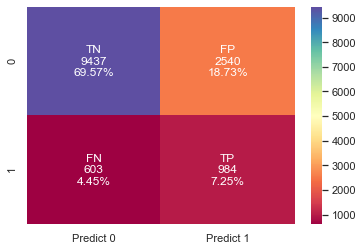

In [338]:
plot_confusion_matrix(bagging_clf, X_test, y_test)

The bagging model generalizes well but Precision is very low at 0.279

We will tune the classifier to see if we can improve performance.

In [339]:
# Create a new classifier
bagging_clf_tuned = BaggingClassifier(base_estimator=logistic_classifier, 
                                random_state=1,
                                n_jobs=-1)

# define what hyperparameter to iterate on
parameters = {
    'max_samples': [0.7, 0.8, 0.9],
    'max_features': [0.7, 0.8, 0.9],
    'n_estimators': [20, 30, 40]
}

# define metric of interest
precision_scorer = metrics.make_scorer(metrics.precision_score)

start_time = time.time()

grid_obj = GridSearchCV(estimator=bagging_clf_tuned,
                       param_grid=parameters,
                       n_jobs=-1,
                       scoring=precision_scorer)
grid_obj.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 352.5789589881897


In [340]:
# get the best estimator
bagging_clf_tuned = grid_obj.best_estimator_

# fit the best estimator to the train data
bagging_clf_tuned.fit(X_train, y_train)

# get metrics
bagging_tuned_metrics = get_metrics_score(bagging_clf_tuned, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.763895471924669
Accuracy - test          :  0.7643025656148629
Recall - training        :  0.6307401404646137
Recall - test            :  0.6175173282923756
Precision - training     :  0.27665876777251186
Precision - test         :  0.27450980392156865
F1 - training            :  0.38461538461538464
F1 - test                :  0.3800659298041497


In [341]:
bagging_clf_tuned.get_params

<bound method BaseEstimator.get_params of BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced'),
                  max_features=0.8, max_samples=0.8, n_estimators=30, n_jobs=-1,
                  random_state=1)>

There is a slight decrease to the Precision but not significant.



Accuracy=0.764
Precision=0.275
Recall=0.618
F1 Score=0.380


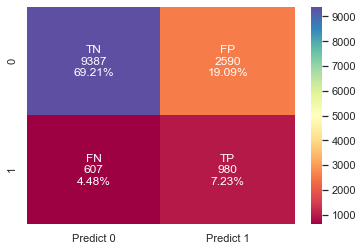

In [342]:
plot_confusion_matrix(bagging_clf_tuned, X_test, y_test)

There is still a large number of False Positive

#### Build Random Forest classifier

In [343]:
### Build a Random Forest classifier
random_forest_clf = RandomForestClassifier(class_weight='balanced',
                                           random_state=1,
                                          n_jobs=-1)
start_time = time.time()
# fit the classifier to the train data
random_forest_clf.fit(X_train, y_train)
print(f'Elapsed time: {time.time() - start_time}')

# get metrics
random_forest_metrics = get_metrics_score(random_forest_clf, X_train, X_test, y_train, y_test)

Elapsed time: 0.9690485000610352
Accuracy - training      :  0.9999684014282555
Accuracy - test          :  0.8919935122382778
Recall - training        :  0.9997298757428417
Recall - test            :  0.1953371140516698
Precision - training     :  1.0
Precision - test         :  0.6224899598393574
F1 - training            :  0.9998649196271782
F1 - test                :  0.2973621103117506




Accuracy=0.892
Precision=0.622
Recall=0.195
F1 Score=0.297


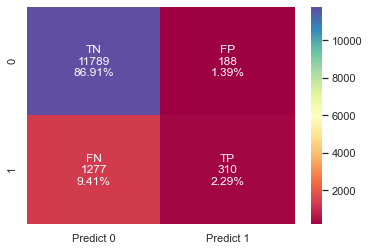

In [344]:
plot_confusion_matrix(random_forest_clf, X_test, y_test)

As expected the model is overfit with a Precision of 1.0 for train and 0.62 for test.

However, its performance is higher than the bagging classfier with logistic regression.

Recall is very low at 0.195 for test.

##### Random Forest performance tuning
We will tune the model to see if we can get better performance.

In [345]:
# get an instance of the classifier
random_forest_clf_tuned = RandomForestClassifier(class_weight='balanced',
                                           random_state=1,
                                          n_jobs=-1)

# define hyperparameters space
parameters = {
    'n_estimators' : [100, 200],
    'max_depth' : [3, 5, 7],
    'max_features' : ['sqrt','log2'],
    'criterion' : ['gini','entropy'],
    'min_samples_leaf' : [5,10,15],
    'min_samples_split' : [7,15,20],
}

start_time = time.time()

# define grid search
grid_obj = GridSearchCV(estimator=random_forest_clf_tuned,
                        param_grid=parameters,
                       scoring=precision_scorer,
                       n_jobs=-1,
                       )

# fit over train data
grid_obj.fit(X_train, y_train)
print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 329.8137216567993


In [346]:
# get the best estimator
random_forest_clf_tuned = grid_obj.best_estimator_

# fit the estimator on the train data
random_forest_clf_tuned.fit(X_train, y_train)

# get metrics
random_forest_tuned_metrics = get_metrics_score(random_forest_clf_tuned,
                                               X_train, X_test, y_train, y_test)

Accuracy - training      :  0.8125256738395424
Accuracy - test          :  0.8122972574461811
Recall - training        :  0.6118314424635333
Recall - test            :  0.5973534971644613
Precision - training     :  0.3350096139624316
Precision - test         :  0.3320490367775832
F1 - training            :  0.432954219631081
F1 - test                :  0.4268347591175147


In [347]:
random_forest_clf_tuned.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, max_features='log2', min_samples_leaf=5,
                       min_samples_split=7, n_estimators=200, n_jobs=-1,
                       random_state=1)>

Precision is higher but still low at 0.332 for test and the model is not overfit.

Recall is now at 0.597



Accuracy=0.812
Precision=0.332
Recall=0.597
F1 Score=0.427


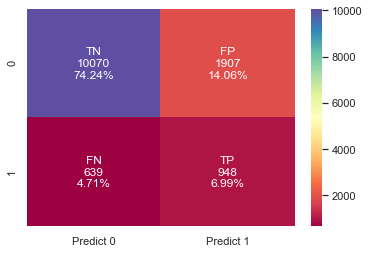

In [348]:
plot_confusion_matrix(random_forest_clf_tuned, X_test, y_test)

#### Build Decision Tree classifier

In [349]:
# get decision tree instance
decision_tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=1)

# fit train data
decision_tree_clf.fit(X_train, y_train)

# get metrics
decision_tree_metrics = get_metrics_score(decision_tree_clf, 
                                          X_train, X_test, 
                                          y_train, y_test)


Accuracy - training      :  1.0
Accuracy - test          :  0.8363314656443527
Recall - training        :  1.0
Recall - test            :  0.28040327662255826
Precision - training     :  1.0
Precision - test         :  0.29218647406434667
F1 - training            :  1.0
F1 - test                :  0.28617363344051444




Accuracy=0.836
Precision=0.292
Recall=0.280
F1 Score=0.286


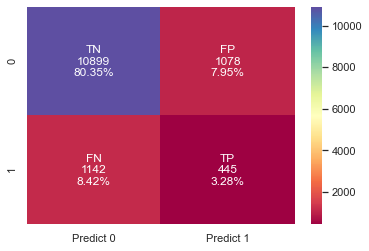

In [350]:
plot_confusion_matrix(decision_tree_clf, X_test, y_test)

The model is overfit.  Performance on test data is very low with a precision of 0.292.

We will perform cost complexity tuning to see if we can improve performance.

#### Decision tree cost complexity pruning

In [351]:
# get set of alphas and impurities
path = decision_tree_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [352]:
path_df = pd.DataFrame(path)
path_df.head(6)

,ccp_alphas,impurities
0,0.000000e+00,-3.905775e-16
1,1.191866e-20,-3.905656e-16
2,1.191866e-20,-3.905536e-16
3,1.191866e-20,-3.905417e-16
4,1.191866e-20,-3.905298e-16
5,1.191866e-20,-3.905179e-16


In [353]:
path_df.tail(6)

,ccp_alphas,impurities
2461,0.003823,0.410995
2462,0.006459,0.417453
2463,0.007499,0.424952
2464,0.010330,0.435282
2465,0.022459,0.457741
2466,0.042259,0.500000


Build decision tree models for all the alphas

In [354]:
dt_clf_list = []

start_time = time.time()

# train trees with various alphas
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(class_weight='balanced',
                                random_state=1,
                                ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    dt_clf_list.append(clf)

print(f'Elapsed time: {time.time() - start_time}')
    
# print last classifier
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        dt_clf_list[-1].tree_.node_count, ccp_alphas[-1]
    ))

Elapsed time: 946.4360792636871
Number of nodes in the last tree is: 1 with ccp_alpha: 0.04225941885953055


We will remove the last classifier as it is a trivial tree with only one node.

In [355]:
# remove last model
dt_clf_list = dt_clf_list[:-1]
# remove last alpha
ccp_alphas = ccp_alphas[:-1]

In [356]:
# get precisions for train and test 
dt_test_precisions = []
dt_train_precisions = []

start_time = time.time()

for clf in dt_clf_list:
    predicted_train = clf.predict(X_train)
    precision = metrics.precision_score(y_train, predicted_train)
    dt_train_precisions.append(precision)
    predicted_test = clf.predict(X_test)
    precision = metrics.precision_score(y_test, predicted_test)
    dt_test_precisions.append(precision)
    
print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 110.61376714706421


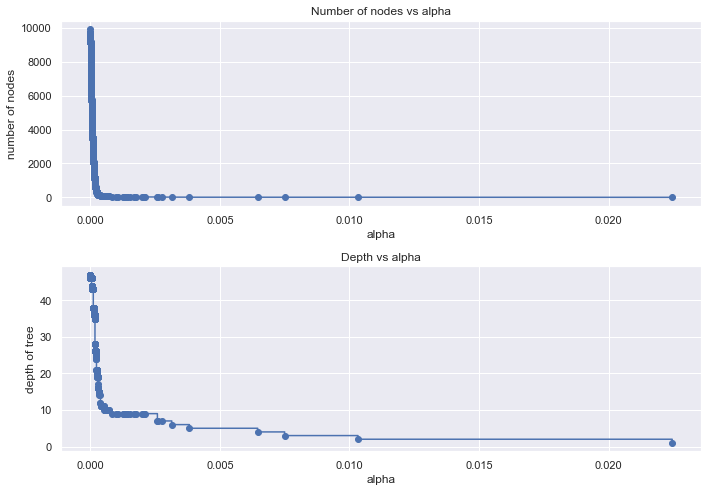

In [357]:
# plot node count vs alpha
node_counts = [clf.tree_.node_count for clf in dt_clf_list]
depth = [clf.tree_.max_depth for clf in dt_clf_list]
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Plot precision score for the various alpha values

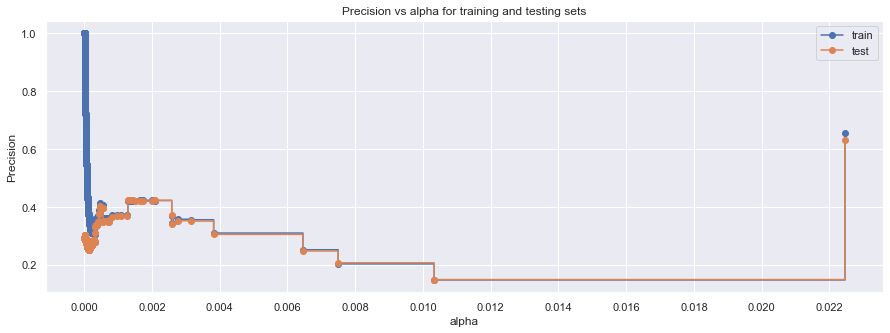

In [358]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_xlabel("alpha")
ax.set_ylabel("Precision")
ax.set_title("Precision vs alpha for training and testing sets")
ax.plot(
    ccp_alphas, dt_train_precisions, marker="o", label="train", drawstyle="steps-post",
)
ax.set_xticks(np.arange(0,0.05,0.002))
ax.grid(markevery=10, which='major')
ax.plot(ccp_alphas, dt_test_precisions, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [359]:
best_model_idx = np.argmax(dt_test_precisions)
print(f'best model index: {best_model_idx}')
print(f'Length of precision list: {len(dt_test_precisions)}')
best_dt = dt_clf_list[best_model_idx]
metrics.precision_score(y_test, best_dt.predict(X_test))

best model index: 2465
Length of precision list: 2466


0.6294642857142857

In [360]:
decision_tree_pruned_metrics = get_metrics_score(best_dt, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.8934180175056088
Accuracy - test          :  0.8915511648481274
Recall - training        :  0.1880064829821718
Recall - test            :  0.1776937618147448
Precision - training     :  0.6547507055503292
Precision - test         :  0.6294642857142857
F1 - training            :  0.29213011542497375
F1 - test                :  0.27714987714987716


Although the best model has a higher precision (0.629) , that is done at the expense of recall which is now extremely low (0.178).



Accuracy=0.892
Precision=0.629
Recall=0.178
F1 Score=0.277


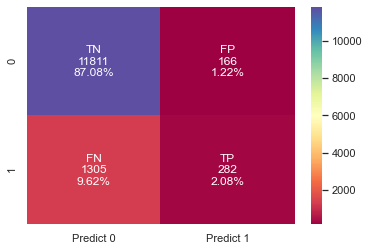

In [361]:
plot_confusion_matrix(best_dt,X_test,y_test)

There is very high number of false negative, which represent opportunity lost for the bank.

We will try further tuning.

#### Decision tree hyperparameters tuning

In [362]:
# instance of decision tree
decision_tree_tuned = DecisionTreeClassifier(class_weight='balanced', random_state=1,)

# hyperparameters space
parameters = {
    'max_depth': np.arange(2, 15, 2),
    'min_samples_leaf': [5,7,10],
    'max_leaf_nodes': [2, 3, 5, 10, 15],
    'min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]
}

start_time = time.time()

# Grid search 
grid_obj = GridSearchCV(decision_tree_tuned, param_grid=parameters,
                       scoring=precision_scorer,
                       n_jobs=-1)
grid_obj.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 48.399112939834595


In [363]:
# get best estimator
decision_tree_tuned = grid_obj.best_estimator_

# fit the best model
decision_tree_tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=2,
                       min_impurity_decrease=0.0001, min_samples_leaf=5,
                       random_state=1)

In [364]:
# get metrics
decision_tree_hyp_tuned_metrics = get_metrics_score(decision_tree_tuned,
                                                   X_train, X_test,
                                                   y_train, y_test)

Accuracy - training      :  0.8934180175056088
Accuracy - test          :  0.8915511648481274
Recall - training        :  0.1880064829821718
Recall - test            :  0.1776937618147448
Precision - training     :  0.6547507055503292
Precision - test         :  0.6294642857142857
F1 - training            :  0.29213011542497375
F1 - test                :  0.27714987714987716


Performance is similar to the cost complexity pruned tree.



Accuracy=0.892
Precision=0.629
Recall=0.178
F1 Score=0.277


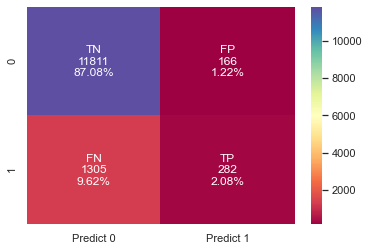

In [365]:
plot_confusion_matrix(decision_tree_tuned, X_test, y_test)

There is a high number of false negative (1236) and still significant number of false positive.

### Boosting models

#### Adaboost

In [366]:
# get instance of classifier
adaboost_clf = AdaBoostClassifier(random_state=1)

start_time = time.time()

# train the classifier
adaboost_clf.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 1.835202693939209


In [367]:
# get metrics
adaboost_metrics = get_metrics_score(adaboost_clf, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.8918696874901254
Accuracy - test          :  0.892214685933353
Recall - training        :  0.20043219881145327
Recall - test            :  0.1947069943289225
Precision - training     :  0.6162790697674418
Precision - test         :  0.6267748478701826
F1 - training            :  0.3024867509172442
F1 - test                :  0.2971153846153846




Accuracy=0.892
Precision=0.627
Recall=0.195
F1 Score=0.297


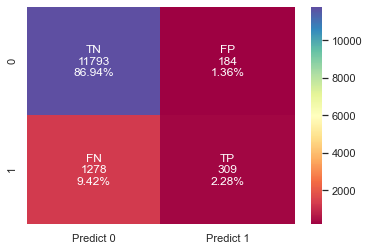

In [368]:
plot_confusion_matrix(adaboost_clf, X_test, y_test)

The model is not overfit but performance is low.  While the Precision is at 0.627 that come at the cost of low recall of 0.195.

We will tune the model hyperparameters.

In [369]:
# get instance
adaboost_clf_tuned = AdaBoostClassifier(random_state=1)

# hyperparameters space
parameters = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1, random_state=1), 
                       DecisionTreeClassifier(max_depth=2, random_state=1),
                       DecisionTreeClassifier(max_depth=3, random_state=1),
                      LogisticRegression(random_state=1)],
    'n_estimators': [25, 50, 75],
    'learning_rate': np.arange(0.2, 1.4, 0.2)
}

start_time = time.time()

# get grid search instance
grid_obj = GridSearchCV(adaboost_clf_tuned, 
                        param_grid=parameters,
                        scoring=precision_scorer,
                        n_jobs=-1)
grid_obj.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 268.7119925022125


In [370]:
# get best estimator
adaboost_clf_tuned = grid_obj.best_estimator_

# fit on train
adaboost_clf_tuned.fit(X_train, y_train)

# get metrics
adaboot_clf_tuned_metrics = get_metrics_score(adaboost_clf_tuned, X_train, X_test,
                                             y_train, y_test)

Accuracy - training      :  0.8839384459822416
Accuracy - test          :  0.8838100855204954
Recall - training        :  0.01242571582928147
Recall - test            :  0.010712035286704474
Precision - training     :  0.7301587301587301
Precision - test         :  0.7391304347826086
F1 - training            :  0.024435590969455516
F1 - test                :  0.021118012422360246


In [371]:
adaboost_clf_tuned.get_params

<bound method BaseEstimator.get_params of AdaBoostClassifier(base_estimator=LogisticRegression(random_state=1),
                   learning_rate=0.4, random_state=1)>



Accuracy=0.884
Precision=0.739
Recall=0.011
F1 Score=0.021


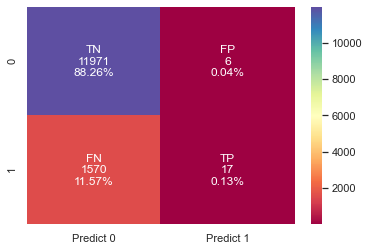

In [372]:
plot_confusion_matrix(adaboost_clf_tuned, X_test, y_test)

Precision on the test data is higher at 0.739.  However, there is a huge number of false negatives (recall=0.011).

### Fit gradient boost model

In [373]:
gradboost_clf = GradientBoostingClassifier(random_state=1)

start_time = time.time()

gradboost_clf.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 5.683041095733643


In [374]:
gradboost_clf_metrics = get_metrics_score(gradboost_clf, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.898758176130439
Accuracy - test          :  0.8936891772338543
Recall - training        :  0.23149648838465695
Recall - test            :  0.20478890989287965
Precision - training     :  0.7047697368421053
Precision - test         :  0.6435643564356436
F1 - training            :  0.3485156567710452
F1 - test                :  0.31070745697896746




Accuracy=0.894
Precision=0.644
Recall=0.205
F1 Score=0.311


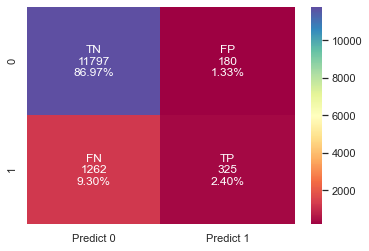

In [375]:
plot_confusion_matrix(gradboost_clf, X_test, y_test)

The gradient boost classifier returns a precision score of 0.644 on test data but it's overfit compared to other models with precision for training at 0.704

Recall is low at 0.205.

We will tune the hyperparameters.

In [376]:
gradboost_clf_tuned = GradientBoostingClassifier(random_state=1)

parameters = { 'n_estimators': [100, 150, 200, 250],
              'subsample': [0.7,0.8,0.9,1.0],
              'max_features': [0.8,0.9,1.0],
              'learning_rate': [0.1, 0.2]
}

start_time = time.time()

grid_obj = GridSearchCV(gradboost_clf_tuned, 
                        param_grid=parameters,
                        scoring=precision_scorer,
                        n_jobs=-1)

grid_obj.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 468.25709438323975


In [377]:
gradboost_clf_tuned = grid_obj.best_estimator_

gradboost_clf_tuned.fit(X_train, y_train)

gradboost_tuned_metrics = get_metrics_score(gradboost_clf_tuned,X_train, X_test, y_train, y_test)

Accuracy - training      :  0.9008120832938351
Accuracy - test          :  0.8931731052786789
Recall - training        :  0.2547271745002701
Recall - test            :  0.21298046628859482
Precision - training     :  0.7127739984882842
Precision - test         :  0.6282527881040892
F1 - training            :  0.3753233830845771
F1 - test                :  0.31811764705882356


In [378]:
gradboost_clf_tuned.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(max_features=0.8, n_estimators=150, random_state=1)>



Accuracy=0.893
Precision=0.628
Recall=0.213
F1 Score=0.318


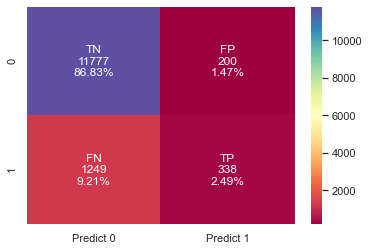

In [379]:
plot_confusion_matrix(gradboost_clf_tuned, X_test, y_test)

Performance is very similar to the previous model

#### Train an XGBoost model 

In [380]:
# get instance of classifiers
xgb_clf = XGBClassifier(random_state=1, n_jobs=-1, eval_metric='logloss')

start_time = time.time()

xgb_clf.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 1.7876386642456055


In [381]:
xbg_clf_metrics = get_metrics_score(xgb_clf, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.9270388978418176
Accuracy - test          :  0.8920672368033029
Recall - training        :  0.4273365748244192
Recall - test            :  0.2589792060491493
Precision - training     :  0.8932806324110671
Precision - test         :  0.5879828326180258
F1 - training            :  0.5781107253791339
F1 - test                :  0.35958005249343833




Accuracy=0.892
Precision=0.588
Recall=0.259
F1 Score=0.360


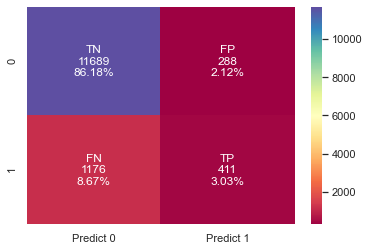

In [382]:
plot_confusion_matrix(xgb_clf, X_test, y_test)

The model overfits the data with a train precision of 0.893 for train and 0.588 for test

We will tune the hyperparameters for XGBoost to see if we can get better performance.

In [383]:
# get instance of classifier
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# hyperparameters space
parameters = {
    'n_estimators' : np.arange(40, 100, 20),
    'subsample': [0.5, 0.7, 0.9],
    'learning_rate': [0.01, 0.1, 0.05],
    'gamma': [0,1,3],
    'colsample_bytree': [0.5,0.7,0.9],
    'colsample_bylevel':[0.5,0.7,0.9],
}

# get grid instance
grid_obj = GridSearchCV(xgb_tuned, 
                        param_grid=parameters,
                        scoring=precision_scorer,
                       n_jobs=1)
start_time = time.time()

grid_obj.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 3128.5555341243744


In [384]:
xgb_tuned = grid_obj.best_estimator_

xgb_tuned.fit(X_train, y_train)

xgb_tuned_metrics = get_metrics_score(xgb_tuned, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.8956931146712168
Accuracy - test          :  0.8939840754939545
Recall - training        :  0.1585629389519179
Recall - test            :  0.14933837429111532
Precision - training     :  0.759379042690815
Precision - test         :  0.7292307692307692
F1 - training            :  0.2623463687150838
F1 - test                :  0.247907949790795




Accuracy=0.894
Precision=0.729
Recall=0.149
F1 Score=0.248


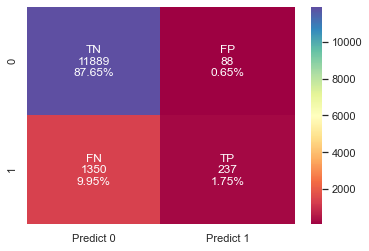

In [385]:
plot_confusion_matrix(xgb_tuned, X_test, y_test)

In [386]:
xgb_tuned.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=3, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=40, n_jobs=12,
              num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.7, tree_method='exact',
              validate_parameters=1, verbosity=None)>

The model performance has improved wrt precision (0.729 for test data) but at the expense of recall (0.149).

#### Stacking Model
We will now train a stacking classifier using the best models built so far.

In [387]:
classifiers = [('Decision Tree', decision_tree_tuned),
               ('Random Forest', random_forest_clf_tuned), 
               ('Adaboost', adaboost_clf_tuned),
              ('Gradient Boost', gradboost_clf_tuned)]

final_estimator = xgb_tuned

stacking_clf = StackingClassifier(estimators=classifiers, final_estimator=final_estimator)

start_time = time.time()

stacking_clf.fit(X_train, y_train)

print(f'Elapsed time: {time.time() - start_time}')

Elapsed time: 96.27969431877136


In [388]:
stacking_clf_metrics = get_metrics_score(stacking_clf, X_train, X_test, y_train, y_test)

Accuracy - training      :  0.8956299175277277
Accuracy - test          :  0.8942052491890298
Recall - training        :  0.17828200972447325
Recall - test            :  0.16761184625078765
Precision - training     :  0.7166123778501629
Precision - test         :  0.7
F1 - training            :  0.28552887735236854
F1 - test                :  0.2704626334519573




Accuracy=0.894
Precision=0.700
Recall=0.168
F1 Score=0.270


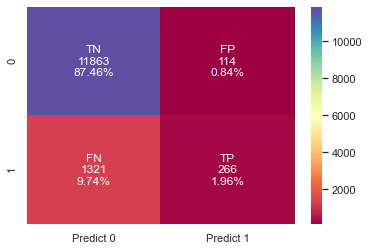

In [389]:
plot_confusion_matrix(stacking_clf, X_test, y_test)

Performance of the stacking classifier is slightly lower than the xgboost with Precision at 0.7 for test data and recall of 0.168.

#### Compare models performance


In [390]:
# list of models and their metrics
models = [['Bagging', bagging_metrics],
         ['Bagging tuned', bagging_tuned_metrics],
         ['Random forest', random_forest_metrics],
         ['Random forest tuned', random_forest_tuned_metrics],
         ['Decision tree', decision_tree_metrics],
         ['Decision Tree CCP', decision_tree_pruned_metrics],
         ['Decision Tree Tuned', decision_tree_hyp_tuned_metrics],
         ['Adaboost', adaboost_metrics],
         ['Adaboost Tuned', adaboot_clf_tuned_metrics],
         ['GradientBoost', gradboost_clf_metrics],
         ['GradientBoost tuned',gradboost_tuned_metrics],
         ['XGBoost', xbg_clf_metrics],
         ['XGBoost tuned', xgb_tuned_metrics],
         ['Stacking', stacking_clf_metrics]]

In [391]:
# build metrics dataframe
model_names = [a[0] for a in models]
acc_train = [a[1][0] for a in models]
acc_test = [a[1][1] for a in models]
rec_train = [a[1][2] for a in models]
rec_test = [a[1][3] for a in models]
prec_train = [a[1][4] for a in models]
prec_test = [a[1][5] for a in models]
f1_train = [a[1][6] for a in models]
f1_test = [a[1][7] for a in models]

compare_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy Train': acc_train,
    'Accuracy Test': acc_test,
    'Recall Train': rec_train,
    'Recall Test': rec_test,
    'Precision Train': prec_train,
    'Precision Test': prec_test,
    'F1 Train': f1_train,
    'F1 Test': f1_test
}
)

# output metrics sorted by Precision Test descending
compare_df.sort_values(by='Precision Test', ascending=False)
        

,Model,Accuracy Train,Accuracy Test,Recall Train,Recall Test,Precision Train,Precision Test,F1 Train,F1 Test
8,Adaboost Tuned,0.883938,0.883810,0.012426,0.010712,0.730159,0.739130,0.024436,0.021118
12,XGBoost tuned,0.895693,0.893984,0.158563,0.149338,0.759379,0.729231,0.262346,0.247908
13,Stacking,0.895630,0.894205,0.178282,0.167612,0.716612,0.700000,0.285529,0.270463
9,GradientBoost,0.898758,0.893689,0.231496,0.204789,0.704770,0.643564,0.348516,0.310707
5,Decision Tree CCP,0.893418,0.891551,0.188006,0.177694,0.654751,0.629464,0.292130,0.277150
6,Decision Tree Tuned,0.893418,0.891551,0.188006,0.177694,0.654751,0.629464,0.292130,0.277150
10,GradientBoost tuned,0.900812,0.893173,0.254727,0.212980,0.712774,0.628253,0.375323,0.318118
7,Adaboost,0.891870,0.892215,0.200432,0.194707,0.616279,0.626775,0.302487,0.297115
2,Random forest,0.999968,0.891994,0.999730,0.195337,1.000000,0.622490,0.999865,0.297362
11,XGBoost,0.927039,0.892067,0.427337,0.258979,0.893281,0.587983,0.578111,0.359580


* The best precision for test is from the tuned Adaboost model at 0.739.  The model is not overfit.
* XGBoost tuned model has slightly lower precision in test (0.729) but has higher recall (0.149 vs 0.0107).
* The best f-1 score is from the random forest tuned model at 0.42 but precision is low at 0.332.

We will choose the tuned adaboost model for our predictions.

##### Feature importance
Although we have chosen the Adaboost tuned model for our predictions it doesn't have a way to determine feature importance.

We will use the next best model, the tuned xgboost, to assess the importance of the features.

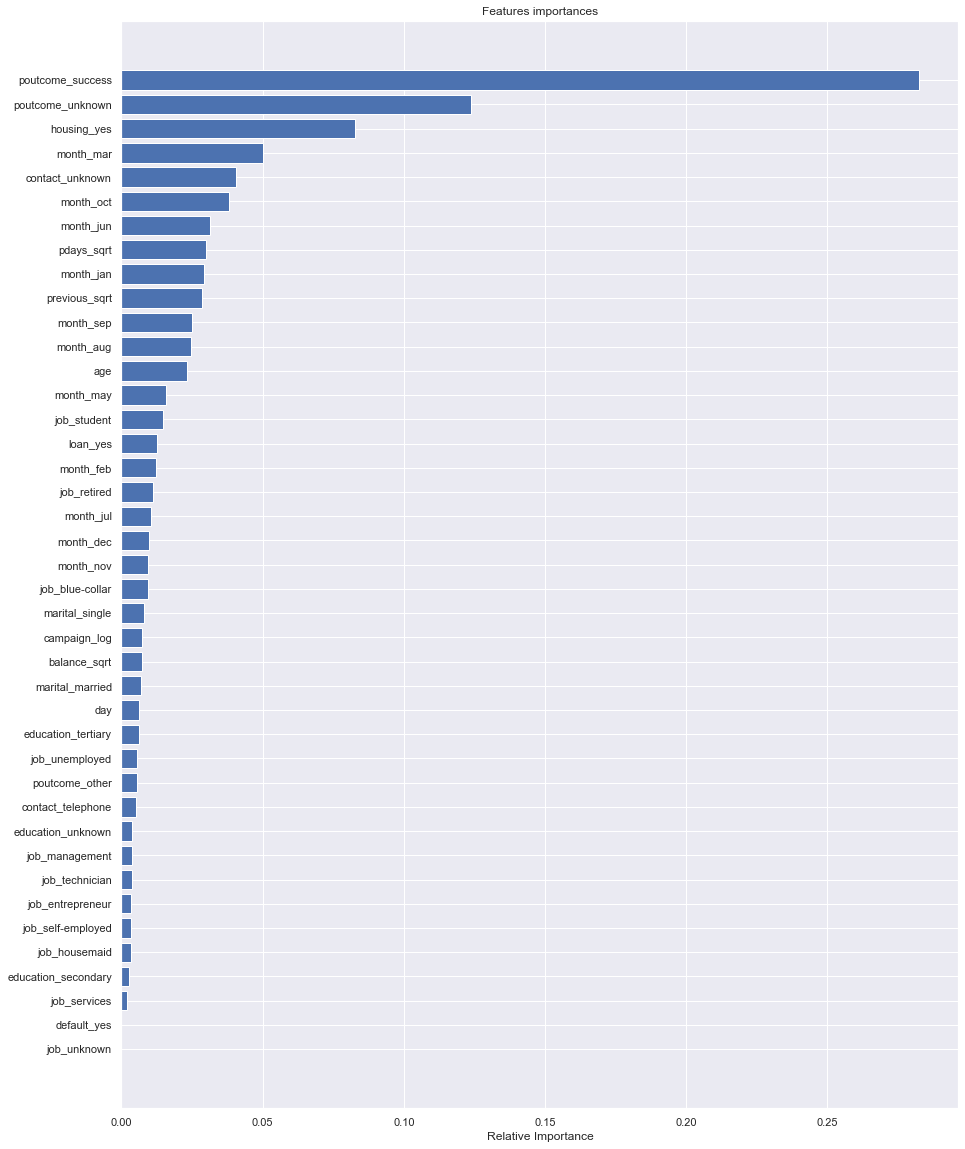

In [392]:
features_names = X_train.columns
importance = xgb_tuned.feature_importances_
sorted_indexes  = np.argsort(importance)

plt.figure(figsize=(15, 20))
plt.title('Features importances')
plt.barh(range(len(sorted_indexes)), importance[sorted_indexes], align='center')
plt.yticks(range(len(sorted_indexes)), [features_names[i] for i in sorted_indexes])
plt.xlabel('Relative Importance')
plt.show()

* The `poutcome_success` has by far the highest importance, followed by `poutcome_unknown`, `housing_yes` and `month_mar`.

## Business Recommendations
* Analysis shows that customers who were succesfully engaged in a previous marketing campaign are more likely to create term deposits.
* However, customers who have never been contacted previously (`poutcome` = 'unknown') represent an opportunity to grow term deposits as they currently have the lowest adoption
* Customers without a housing loan are more likely to take out a term loan and therefore should continue to be targeted
* As the models have limited predictive power, consideration should be given to collecting additional features to increase the predictive power of future models

In [393]:
print(f'Elapsed time: {time.time() - overall_start_time}')

Elapsed time: 6086.078074455261
